# Image Detection - Car Damage Detector


In the following Notebook, we're going to build an Image Classifier which can detect whether the image of a car exhibits damage or not. 

In order to acheive this, we're going to use a combination of a pre-trained Model and Transfer learning to learn from a new dataset of cars. The new dataset will contain cars with and without damage. The Orginal Dataset can be found here: 

https://storage.googleapis.com/kaggle-data-sets/278578/575693/bundle/archive.zip?GoogleAccessId=web-data@kaggle-161607.iam.gserviceaccount.com&Expires=1580452098&Signature=PAEfJV9YaDrFvPgisbNL8eLIyJb6GQSp0jjIVGPxE6pn4mIh%2FZa9KBiSdCWZdqcDl5vp4p9k2Vtfu7BH30%2Br4HQfu4OO0bTNAjsrK6bxhvzNOdv%2BrEtDCHciHv


An additional set of resources which have been helpful in this example can be found here:

http://ai.stanford.edu/~jkrause/cars/car_dataset.html


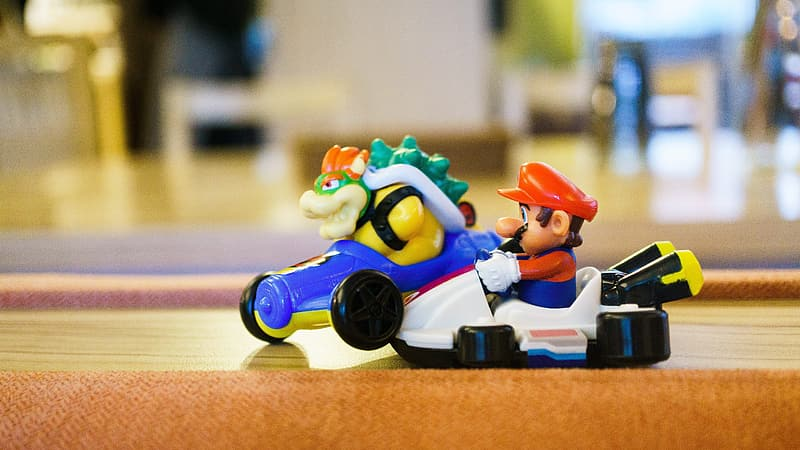


### General Imports

These are the libraries which we will require in order to complete different types of operations

In [54]:
import boto3
import sagemaker
import sys
import os
import re
import numpy as np
import pandas as pd
import subprocess
from sagemaker import get_execution_role
from sagemaker.amazon.amazon_estimator import get_image_uri
import gzip
from io import BytesIO
import zipfile
import random
import json
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.metrics import classification_report


## Part 1. Car Damage Detector

In part 1, we're going to download our data, structure it, and use it to train a pre-trained image classification algorithm to detect damage on a car

### Constant Set-up
Configure all global constants here, these are variables which will remain constant throughout the execution of the notebook.

In [55]:

# NOTE: S3 bucket name must begin with "deeplens-" for DeepLens deployment
bucket_name='dataset-cars-damage'
prefix = '' #only use this if you want to have your files in a folder 
dataset_filename = 'car-damage-dataset.zip'
dataset_unpacked_dir = 'car-damage-dataset/'

### Environment Setup

Setting up the environment involves ensuring all the corret session and IAM roles are configured. We also need to ensure the correct region and bucket is made available.

In [ ]:
def setup_env():
    
    role = get_execution_role()

    sess = sagemaker.Session()

    
    AWS_REGION = 'us-east-1'
    s3 = boto3.resource('s3')

    s3_bucket = s3.Bucket(bucket_name)

    if s3_bucket.creation_date == None:
    # create S3 bucket because it does not exist yet
        print('Creating S3 bucket {}.'.format(bucket))
        resp = s3.create_bucket(
            ACL='private',
            Bucket=bucket
        )
    else:
        print('Bucket already exists')
    return role, sess, AWS_REGION, s3,s3_bucket

role, sess,  AWS_REGION, s3, s3_bucket = setup_env()

### Download Data and Create Manifest

Here we are goin to download the data to our bucket if it does not already exist. This dataset is a pre-compiled dataset of car images which contain 2 typers:

- Whole (e.g. without damage)
- Damaged (e.g. those with damage)

The following create_dataset method will first download the Zip of the data, and then unpack it to the bucket named in the global constants



In [ ]:
def create_dataset(bucket_name, s3_bucket):
    
    dataset_key = 'car-damage-dataset.zip'
    objs = list(s3_bucket.objects.filter(Prefix=dataset_key))
    if len(objs) > 0 and objs[0].key == dataset_key:
        exists = True
        print('{} Already Exists'.format(dataset_key) )
    else:
        exists = False
    
    if not exists:
    
        bucket = bucket_name
        #copy first

        source= { 'Bucket' : 'public-datasets', 'Key': dataset_key}
        s3_bucket.copy(source, dataset_key)


        s3 = boto3.client('s3', use_ssl=False)
        Key_unzip = dataset_unpacked_dir

    
        s3_resource = boto3.resource('s3')
        #Now create zip object one by one, this below is for 1st file in file_list
        zip_obj = s3_resource.Object(bucket_name=bucket_name, key=dataset_key)
        print('Unpacking {}\n'.format(dataset_key))
        
        print (zip_obj)
        buffer = BytesIO(zip_obj.get()["Body"].read())
        z = zipfile.ZipFile(buffer)
        for filename in z.namelist():
            file_info = z.getinfo(filename)
            s3_resource.meta.client.upload_fileobj(
                z.open(filename),
                Bucket=bucket_name,
                Key=Key_unzip + f'{filename}')
            
        
    
create_dataset(bucket_name, s3_bucket)

### Create the Dataset Manifest

The manifest file will comprise of a tab separated file, which contains an index (unique for all). the class, and the path to the file (s3 bucket location)

A .lst file is a tab-separated file with three columns that contains a list of image files. The first column specifies the image index, the second column specifies the class label index for the image, and the third column specifies the relative path of the image file. The image index in the first column should be unique across all of the images. Here we make an image list file using the im2rec tool from MXNet. You can also create the .lst file in your own way. An example of .lst file is shown as follows:

01    1.0    filea.jpg <br>
02    2.0    fileb.jpg

When you are bringing your own image files to train, please ensure that the .lst file follows the same format as described above. In order to train with the lst format interface, passing the lst file for both training and validation in the appropriate format is mandatory. Once we have the data available in the correct format for training, the next step is to upload the image and .lst file to S3 bucket.


In [56]:
def create_dataset_manifest(bucket_name, s3, data_path):
    
    manifest_train = []
    manifest_val = []
    
    idx = 0
    conn = boto3.client('s3')  # again assumes boto.cfg setup, assume AWS S3
    
    for file in s3.objects.all():#(Bucket=bucket_name, Prefix=data_path)['Contents']:
        path = file.key
#         print(path)
        if ('.JPEG' in path) or ('.jpeg' in path):
            if 'training' in path:
                man = {}
                relative_path = path.replace('training/','')
#                 print(relative_path)
                if 'damage' in path:
                    data_class = 1.0
                else:
                    data_class = 0.0
                man = {'idx':idx, 'class': data_class, 'path':relative_path, 'path_with_prefix':path}
                manifest_train.append(man)
                
            if 'validation' in path:
                man = {}
                relative_path = path.replace('validation/','')
                if 'damage' in path:
                    data_class = 1.0
                else:
                    data_class = 0.0
                man = {'idx':idx, 'class': data_class, 'path':relative_path, 'path_with_prefix':path}
                manifest_val.append(man)
            idx += 1
    print('Training Dataset Size {}, Validation Size {}'.format(len(manifest_train), len(manifest_val)))
    
    ##Create Augmented JSON Record file
    aug_train = []
    for x in manifest_train:
        absolute_path = 's3://{}/{}'.format(bucket_name, x['path_with_prefix'])
        
        dic = {'source-ref':absolute_path, 'class': str(x['class'])}
        aug_train.append(dic)

    with open('train_manifest.json', 'w') as fout:
        for x in aug_train:
            fout.write(json.dumps(x)+'\n')
            #json.dump(aug_train, fout, indent=4)
    
    val_train = []
    for x in manifest_val:
        absolute_path = 's3://{}/{}'.format(bucket_name, x['path_with_prefix'])
        
        dic = {'source-ref':absolute_path, 'class': str(x['class'])}
        val_train.append(dic)

    with open('val_manifest.json', 'w') as fout:
         for x in val_train:
            fout.write(json.dumps(x)+'\n')

    return manifest_train, manifest_val 
            
manifest_train, manifest_val  = create_dataset_manifest(bucket_name, s3_bucket, '')   
    

Training Dataset Size 105434, Validation Size 26361


In [ ]:
def upload_metadata(s3_bucket):
    
    train_file_s3 = 'train_lst/train_manifest.json'
    s3_bucket.upload_file('./train_manifest.json', train_file_s3)
    val_file_s3 = 'val_lst/val_manifest.json'
    s3_bucket.upload_file('./val_manifest.json', val_file_s3)
    
    
upload_metadata(s3_bucket)


## Configure Classifier

We will be using a pre-trained classifier in order to kick off the training process. A pretrained model allows us to take a model which has already been trained on million's of images, and then use a method known as transfer learning to fine tune the model to predict the specific set of classes which we will use for our detection task.

In [74]:
def setup_classifier():

    training_image = get_image_uri(sess.boto_region_name, 'image-classification', repo_version="latest")
    print (training_image)
    return training_image

training_image = setup_classifier()

811284229777.dkr.ecr.us-east-1.amazonaws.com/image-classification:latest


### Fine-tuning the Image Classification Model
Now that we are done with all the setup that is needed, we are ready to train our object detector. To begin, let us create a sageMaker.estimator.Estimator object. This estimator will launch the training job.

### Training parameters
There are two kinds of parameters that need to be set for training. The first one are the parameters for the training job. These include:

- Training instance count: This is the number of instances on which to run the training. When the number of instances is greater than one, then the image classification algorithm will run in distributed settings.
- Training instance type: This indicates the type of machine on which to run the training. Typically, we use GPU instances for these training
- Output path: This the s3 folder in which the training output is stored

In [85]:
def configure_estimator(bucket_name, sess, training_image):

    s3_output_location = 's3://{}/output'.format(bucket_name)
    ic = sagemaker.estimator.Estimator(training_image,
                                             role, 
                                             train_instance_count=6, 
                                             train_instance_type='ml.p3.16xlarge',
                                             train_volume_size = 50,
                                             train_max_run = 432000,
                                             input_mode= 'Pipe',
                                             output_path=s3_output_location,
                                             sagemaker_session=sess)
    return ic

ic = configure_estimator(bucket_name, sess, training_image)

### Hyperparameter Tuning

Apart from the above set of parameters, there are hyperparameters that are specific to the algorithm. These are:

- **num_layers**: The number of layers (depth) for the network. We use 18 in this samples but other values such as 50, 152 can be used.
use_pretrained_model: Set to 1 to use pretrained model for transfer learning.
- **image_shape**: The input image dimensions,'num_channels, height, width', for the network. It should be no larger than the actual image size. The number of channels should be same as the actual image.
- **num_classes**: This is the number of output classes for the new dataset. Imagenet was trained with 1000 output classes but the number of output classes can be changed for fine-tuning. For caltech, we use 257 because it has 256 object categories + 1 clutter class.
- **num_training_samples**: This is the total number of training samples. It is set to 15240 for caltech dataset with the current split.
- **mini_batch_size**: The number of training samples used for each mini batch. In distributed training, the number of training samples used per batch will be N * mini_batch_size where N is the number of hosts on which training is run.
- **epochs**: Number of training epochs.
- **learning_rate**: Learning rate for training.
- **top_k**: Report the top-k accuracy during training.
- **resize**: Resize the image before using it for training. The images are resized so that the shortest side is of this parameter. If the parameter is not set, then the training data is used as such without resizing.
- **precision_dtype**: Training datatype precision (default: float32). If set to 'float16', the training will be done in mixed_precision mode and will be faster than float32 mode

In [89]:
def configure_hyperparams(ic):
    ic.set_hyperparameters(num_layers=152,
                             use_pretrained_model=1,
                             image_shape = "3,150,250",
                             num_classes=2,
                             mini_batch_size=256,
                             epochs=300,
                             learning_rate=0.001,
                             top_k=1,
                             num_training_samples=105434,
                             precision_dtype='float32')
    
    return ic

ic = configure_hyperparams(ic)

### Configure Data Sources

Based on the data we've created in the s3 bucket, and the manifests associated with these image files, we need to structure this into an object which then is passed to the Estimator.

In [90]:
def configure_data_channels(bucket_name):
    
    s3train = 's3://{}/training'.format(bucket_name)
    s3validation = 's3://{}/validation'.format(bucket_name)
    s3train_lst = 's3://{}/train_lst/'.format(bucket_name)
    s3validation_lst = 's3://{}/val_lst/'.format(bucket_name)
    s3train_manifest = 's3://{}/train_lst/{}'.format(bucket_name,'train_manifest.json')
    s3validation_manifest = 's3://{}/val_lst/{}'.format(bucket_name,'val_manifest.json')
    print(s3train_lst)
    
    attribute_names = ["source-ref","class"]

    
    train_data = sagemaker.session.s3_input(s3train_manifest, 
                                            distribution='FullyReplicated', 
                                            content_type='application/x-image', 
                                            s3_data_type='AugmentedManifestFile',
                                            attribute_names=attribute_names,
                                            record_wrapping='RecordIO')
    
    validation_data = sagemaker.session.s3_input(s3validation_manifest, 
                                                 distribution='FullyReplicated', 
                                                 content_type='application/x-image', 
                                                 s3_data_type='AugmentedManifestFile',
                                                 attribute_names=attribute_names,
                                                 record_wrapping='RecordIO')
    
#     train_data_lst = sagemaker.session.s3_input(s3train_lst, distribution='FullyReplicated', 
#                             content_type='application/x-image', s3_data_type='S3Prefix', record_wrapping='RecordIO')
    
#     validation_data_lst = sagemaker.session.s3_input(s3validation_lst, distribution='FullyReplicated', 
#                                  content_type='application/x-image', s3_data_type='S3Prefix',record_wrapping='RecordIO')

    data_channels = {'train': train_data, 'validation': validation_data}#
#                      'train_lst': train_data_lst, 'validation_lst': validation_data_lst}
    
    
    return data_channels

data_channels = configure_data_channels(bucket_name)

s3://dataset-cars-damage/train_lst/


## Train the model

In [ ]:
def train_model(ic):
    ic.fit(inputs=data_channels, logs=True)
    return ic

ic = train_model(ic)

2020-03-09 02:49:46 Starting - Starting the training job...
2020-03-09 02:49:47 Starting - Launching requested ML instances.........
2020-03-09 02:51:21 Starting - Preparing the instances for training.........
2020-03-09 02:53:06 Downloading - Downloading input data
2020-03-09 02:53:06 Training - Downloading the training image...
2020-03-09 02:53:40 Training - Training image download completed. Training in progress.Docker entrypoint called with argument(s): train
Docker entrypoint called with argument(s): train
Docker entrypoint called with argument(s): train
Docker entrypoint called with argument(s): train
Docker entrypoint called with argument(s): train
[03/09/2020 02:53:36 INFO 139897403668288] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/image_classification/default-input.json: {u'beta_1': 0.9, u'gamma': 0.9, u'beta_2': 0.999, u'optimizer': u'sgd', u'use_pretrained_model': 0, u'eps': 1e-08, u'epochs': 30, u'lr_scheduler_factor': 0.1, u'num_layers': 152

[03/09/2020 02:53:45 INFO 140618399950656] Setting number of threads: 63
[03/09/2020 02:53:45 INFO 139897403668288] Setting number of threads: 63
[03/09/2020 02:53:45 INFO 140253363500864] Setting number of threads: 63
[03/09/2020 02:53:45 INFO 140472338057024] Setting number of threads: 63
[03/09/2020 02:53:45 INFO 140672499640128] Setting number of threads: 63
[03/09/2020 02:53:45 INFO 139805480462144] Setting number of threads: 63
[02:54:41] /opt/brazil-pkg-cache/packages/AIAlgorithmsMXNet/AIAlgorithmsMXNet-1.3.x_ecl_Cuda_10.1.x.2523.0/AL2012/generic-flavor/src/src/operator/nn/./cudnn/./cudnn_algoreg-inl.h:97: Running performance tests to find the best convolution algorithm, this can take a while... (setting env variable MXNET_CUDNN_AUTOTUNE_DEFAULT to 0 to disable)
[02:54:42] /opt/brazil-pkg-cache/packages/AIAlgorithmsMXNet/AIAlgorithmsMXNet-1.3.x_ecl_Cuda_10.1.x.2523.0/AL2012/generic-flavor/src/src/operator/nn/./cudnn/./cudnn_algoreg-inl.h:97: Running performance tests to find the

[03/09/2020 02:58:24 INFO 140618399950656] Epoch[1] Validation-accuracy=0.880992
[03/09/2020 02:58:30 INFO 139805480462144] Epoch[1] Validation-accuracy=0.880992
[03/09/2020 02:58:32 INFO 139897403668288] Epoch[1] Validation-accuracy=0.880992
[03/09/2020 02:58:31 INFO 140472338057024] Epoch[1] Validation-accuracy=0.880992
[03/09/2020 02:58:32 INFO 140672499640128] Epoch[1] Validation-accuracy=0.880992
[03/09/2020 02:58:33 INFO 140253363500864] Epoch[1] Validation-accuracy=0.880992
[03/09/2020 02:58:53 INFO 140672499640128] Epoch[2] Batch [20]#011Speed: 268.716 samples/sec#011accuracy=1.000000
[03/09/2020 02:58:53 INFO 139805480462144] Epoch[2] Batch [20]#011Speed: 269.428 samples/sec#011accuracy=1.000000
[03/09/2020 02:58:53 INFO 140618399950656] Epoch[2] Batch [20]#011Speed: 269.699 samples/sec#011accuracy=1.000000
[03/09/2020 02:58:53 INFO 139897403668288] Epoch[2] Batch [20]#011Speed: 269.593 samples/sec#011accuracy=1.000000
[03/09/2020 02:58:53 INFO 140253363500864] Epoch[2] Batch 

[03/09/2020 03:02:56 INFO 140672499640128] Epoch[4] Batch [40]#011Speed: 313.841 samples/sec#011accuracy=1.000000
[03/09/2020 03:02:56 INFO 139805480462144] Epoch[4] Batch [40]#011Speed: 313.921 samples/sec#011accuracy=1.000000
[03/09/2020 03:02:56 INFO 140618399950656] Epoch[4] Batch [40]#011Speed: 313.899 samples/sec#011accuracy=1.000000
[03/09/2020 03:02:56 INFO 139897403668288] Epoch[4] Batch [40]#011Speed: 313.888 samples/sec#011accuracy=1.000000
[03/09/2020 03:02:56 INFO 140253363500864] Epoch[4] Batch [40]#011Speed: 313.891 samples/sec#011accuracy=1.000000
[03/09/2020 03:02:56 INFO 140472338057024] Epoch[4] Batch [40]#011Speed: 313.311 samples/sec#011accuracy=1.000000
[03/09/2020 03:03:10 INFO 140618399950656] Epoch[4] Batch [60]#011Speed: 333.918 samples/sec#011accuracy=1.000000
[03/09/2020 03:03:10 INFO 139897403668288] Epoch[4] Batch [60]#011Speed: 334.262 samples/sec#011accuracy=1.000000
[03/09/2020 03:03:10 INFO 140253363500864] Epoch[4] Batch [60]#011Speed: 334.188 samples

[03/09/2020 03:07:07 INFO 139897403668288] Epoch[6] Batch [60]#011Speed: 325.525 samples/sec#011accuracy=1.000000
[03/09/2020 03:07:07 INFO 140253363500864] Epoch[6] Batch [60]#011Speed: 325.571 samples/sec#011accuracy=1.000000
[03/09/2020 03:07:07 INFO 140472338057024] Epoch[6] Batch [60]#011Speed: 325.312 samples/sec#011accuracy=1.000000
[03/09/2020 03:07:07 INFO 140672499640128] Epoch[6] Batch [60]#011Speed: 325.247 samples/sec#011accuracy=1.000000
[03/09/2020 03:07:07 INFO 139805480462144] Epoch[6] Batch [60]#011Speed: 325.494 samples/sec#011accuracy=1.000000
[03/09/2020 03:07:07 INFO 140618399950656] Epoch[6] Batch [60]#011Speed: 325.491 samples/sec#011accuracy=1.000000
[03/09/2020 03:07:11 INFO 140472338057024] Epoch[6] Train-accuracy=1.000000
[03/09/2020 03:07:11 INFO 140472338057024] Epoch[6] Time cost=51.609
[03/09/2020 03:07:11 INFO 140672499640128] Epoch[6] Train-accuracy=1.000000
[03/09/2020 03:07:11 INFO 140672499640128] Epoch[6] Time cost=51.627
[03/09/2020 03:07:11 INFO 

[03/09/2020 03:12:03 INFO 140672499640128] Epoch[8] Validation-accuracy=0.880992
[03/09/2020 03:12:05 INFO 140253363500864] Epoch[8] Validation-accuracy=0.880992
[03/09/2020 03:12:06 INFO 140618399950656] Epoch[8] Validation-accuracy=0.880992
[03/09/2020 03:12:07 INFO 139805480462144] Epoch[8] Validation-accuracy=0.880992
[03/09/2020 03:12:14 INFO 140472338057024] Epoch[8] Validation-accuracy=0.880992
[03/09/2020 03:12:18 INFO 139897403668288] Epoch[8] Validation-accuracy=0.880992
[03/09/2020 03:12:42 INFO 139897403668288] Epoch[9] Batch [20]#011Speed: 220.176 samples/sec#011accuracy=1.000000
[03/09/2020 03:12:42 INFO 140618399950656] Epoch[9] Batch [20]#011Speed: 220.140 samples/sec#011accuracy=1.000000
[03/09/2020 03:12:42 INFO 140253363500864] Epoch[9] Batch [20]#011Speed: 220.182 samples/sec#011accuracy=1.000000
[03/09/2020 03:12:42 INFO 140472338057024] Epoch[9] Batch [20]#011Speed: 219.751 samples/sec#011accuracy=1.000000
[03/09/2020 03:12:42 INFO 140672499640128] Epoch[9] Batch 

[03/09/2020 03:16:37 INFO 140253363500864] Epoch[11] Batch [40]#011Speed: 323.862 samples/sec#011accuracy=1.000000
[03/09/2020 03:16:37 INFO 140472338057024] Epoch[11] Batch [40]#011Speed: 323.160 samples/sec#011accuracy=1.000000
[03/09/2020 03:16:37 INFO 140672499640128] Epoch[11] Batch [40]#011Speed: 323.753 samples/sec#011accuracy=1.000000
[03/09/2020 03:16:37 INFO 139805480462144] Epoch[11] Batch [40]#011Speed: 323.807 samples/sec#011accuracy=1.000000
[03/09/2020 03:16:37 INFO 139897403668288] Epoch[11] Batch [40]#011Speed: 323.880 samples/sec#011accuracy=1.000000
[03/09/2020 03:16:37 INFO 140618399950656] Epoch[11] Batch [40]#011Speed: 323.610 samples/sec#011accuracy=1.000000
[03/09/2020 03:16:50 INFO 140672499640128] Epoch[11] Batch [60]#011Speed: 348.782 samples/sec#011accuracy=1.000000
[03/09/2020 03:16:50 INFO 139805480462144] Epoch[11] Batch [60]#011Speed: 349.126 samples/sec#011accuracy=1.000000
[03/09/2020 03:16:50 INFO 139897403668288] Epoch[11] Batch [60]#011Speed: 348.91

[03/09/2020 03:20:38 INFO 140472338057024] Epoch[13] Batch [60]#011Speed: 327.817 samples/sec#011accuracy=1.000000
[03/09/2020 03:20:38 INFO 140672499640128] Epoch[13] Batch [60]#011Speed: 327.827 samples/sec#011accuracy=1.000000
[03/09/2020 03:20:38 INFO 139805480462144] Epoch[13] Batch [60]#011Speed: 328.148 samples/sec#011accuracy=1.000000
[03/09/2020 03:20:38 INFO 139897403668288] Epoch[13] Batch [60]#011Speed: 328.106 samples/sec#011accuracy=1.000000
[03/09/2020 03:20:38 INFO 140618399950656] Epoch[13] Batch [60]#011Speed: 327.831 samples/sec#011accuracy=1.000000
[03/09/2020 03:20:38 INFO 140253363500864] Epoch[13] Batch [60]#011Speed: 328.147 samples/sec#011accuracy=1.000000
[03/09/2020 03:20:42 INFO 140672499640128] Epoch[13] Train-accuracy=1.000000
[03/09/2020 03:20:42 INFO 140672499640128] Epoch[13] Time cost=51.097
[03/09/2020 03:20:42 INFO 139805480462144] Epoch[13] Train-accuracy=1.000000
[03/09/2020 03:20:42 INFO 139805480462144] Epoch[13] Time cost=51.103
[03/09/2020 03:2

[03/09/2020 03:24:20 INFO 140253363500864] Epoch[15] Train-accuracy=1.000000
[03/09/2020 03:24:20 INFO 140253363500864] Epoch[15] Time cost=50.599
[03/09/2020 03:24:20 INFO 140472338057024] Epoch[15] Train-accuracy=1.000000
[03/09/2020 03:24:20 INFO 140472338057024] Epoch[15] Time cost=50.662
[03/09/2020 03:25:10 INFO 139897403668288] Epoch[15] Validation-accuracy=0.880992
[03/09/2020 03:25:12 INFO 140253363500864] Epoch[15] Validation-accuracy=0.880992
[03/09/2020 03:25:14 INFO 140672499640128] Epoch[15] Validation-accuracy=0.880992
[03/09/2020 03:25:14 INFO 140618399950656] Epoch[15] Validation-accuracy=0.880992
[03/09/2020 03:25:15 INFO 139805480462144] Epoch[15] Validation-accuracy=0.880992
[03/09/2020 03:25:25 INFO 140472338057024] Epoch[15] Validation-accuracy=0.880992
[03/09/2020 03:25:48 INFO 140253363500864] Epoch[16] Batch [20]#011Speed: 227.728 samples/sec#011accuracy=1.000000
[03/09/2020 03:25:49 INFO 140472338057024] Epoch[16] Batch [20]#011Speed: 227.037 samples/sec#011ac

[03/09/2020 03:29:24 INFO 140253363500864] Epoch[17] Validation-accuracy=0.880992
[03/09/2020 03:29:43 INFO 140618399950656] Epoch[18] Batch [20]#011Speed: 278.618 samples/sec#011accuracy=1.000000
[03/09/2020 03:29:43 INFO 140253363500864] Epoch[18] Batch [20]#011Speed: 278.449 samples/sec#011accuracy=1.000000
[03/09/2020 03:29:43 INFO 140472338057024] Epoch[18] Batch [20]#011Speed: 277.930 samples/sec#011accuracy=1.000000
[03/09/2020 03:29:43 INFO 140672499640128] Epoch[18] Batch [20]#011Speed: 278.596 samples/sec#011accuracy=1.000000
[03/09/2020 03:29:43 INFO 139805480462144] Epoch[18] Batch [20]#011Speed: 278.692 samples/sec#011accuracy=1.000000
[03/09/2020 03:29:43 INFO 139897403668288] Epoch[18] Batch [20]#011Speed: 278.623 samples/sec#011accuracy=1.000000
[03/09/2020 03:29:58 INFO 139897403668288] Epoch[18] Batch [40]#011Speed: 307.843 samples/sec#011accuracy=1.000000
[03/09/2020 03:29:58 INFO 140618399950656] Epoch[18] Batch [40]#011Speed: 308.168 samples/sec#011accuracy=1.00000

[03/09/2020 03:43:07 INFO 140253363500864] Epoch[25] Batch [40]#011Speed: 298.223 samples/sec#011accuracy=1.000000
[03/09/2020 03:43:07 INFO 140472338057024] Epoch[25] Batch [40]#011Speed: 297.921 samples/sec#011accuracy=1.000000
[03/09/2020 03:43:07 INFO 140672499640128] Epoch[25] Batch [40]#011Speed: 297.920 samples/sec#011accuracy=1.000000
[03/09/2020 03:43:07 INFO 139805480462144] Epoch[25] Batch [40]#011Speed: 298.031 samples/sec#011accuracy=1.000000
[03/09/2020 03:43:07 INFO 139897403668288] Epoch[25] Batch [40]#011Speed: 298.326 samples/sec#011accuracy=1.000000
[03/09/2020 03:43:07 INFO 140618399950656] Epoch[25] Batch [40]#011Speed: 298.288 samples/sec#011accuracy=1.000000
[03/09/2020 03:43:20 INFO 139897403668288] Epoch[25] Batch [60]#011Speed: 326.502 samples/sec#011accuracy=1.000000
[03/09/2020 03:43:20 INFO 140618399950656] Epoch[25] Batch [60]#011Speed: 326.436 samples/sec#011accuracy=1.000000
[03/09/2020 03:43:20 INFO 140253363500864] Epoch[25] Batch [60]#011Speed: 326.50

[03/09/2020 03:47:09 INFO 140672499640128] Epoch[27] Batch [60]#011Speed: 326.293 samples/sec#011accuracy=1.000000
[03/09/2020 03:47:09 INFO 139805480462144] Epoch[27] Batch [60]#011Speed: 326.358 samples/sec#011accuracy=1.000000
[03/09/2020 03:47:09 INFO 139897403668288] Epoch[27] Batch [60]#011Speed: 326.370 samples/sec#011accuracy=1.000000
[03/09/2020 03:47:09 INFO 140618399950656] Epoch[27] Batch [60]#011Speed: 326.313 samples/sec#011accuracy=1.000000
[03/09/2020 03:47:09 INFO 140253363500864] Epoch[27] Batch [60]#011Speed: 326.315 samples/sec#011accuracy=1.000000
[03/09/2020 03:47:09 INFO 140472338057024] Epoch[27] Batch [60]#011Speed: 325.995 samples/sec#011accuracy=1.000000
[03/09/2020 03:47:14 INFO 139897403668288] Epoch[27] Train-accuracy=1.000000
[03/09/2020 03:47:14 INFO 139897403668288] Epoch[27] Time cost=51.438
[03/09/2020 03:47:14 INFO 140618399950656] Epoch[27] Train-accuracy=1.000000
[03/09/2020 03:47:14 INFO 140618399950656] Epoch[27] Time cost=51.443
[03/09/2020 03:4

[03/09/2020 03:51:55 INFO 140472338057024] Epoch[29] Validation-accuracy=0.880992
[03/09/2020 03:51:55 INFO 139805480462144] Epoch[29] Validation-accuracy=0.880992
[03/09/2020 03:51:59 INFO 140253363500864] Epoch[29] Validation-accuracy=0.880992
[03/09/2020 03:52:00 INFO 139897403668288] Epoch[29] Validation-accuracy=0.880992
[03/09/2020 03:52:01 INFO 140618399950656] Epoch[29] Validation-accuracy=0.880992
[03/09/2020 03:52:05 INFO 140672499640128] Epoch[29] Validation-accuracy=0.880992
[03/09/2020 03:52:25 INFO 140253363500864] Epoch[30] Batch [20]#011Speed: 267.079 samples/sec#011accuracy=1.000000
[03/09/2020 03:52:25 INFO 140472338057024] Epoch[30] Batch [20]#011Speed: 266.187 samples/sec#011accuracy=1.000000
[03/09/2020 03:52:25 INFO 140672499640128] Epoch[30] Batch [20]#011Speed: 267.130 samples/sec#011accuracy=1.000000
[03/09/2020 03:52:25 INFO 139805480462144] Epoch[30] Batch [20]#011Speed: 267.059 samples/sec#011accuracy=1.000000
[03/09/2020 03:52:25 INFO 139897403668288] Epoch

[03/09/2020 03:56:43 INFO 140253363500864] Epoch[32] Batch [40]#011Speed: 298.211 samples/sec#011accuracy=1.000000
[03/09/2020 03:56:43 INFO 140472338057024] Epoch[32] Batch [40]#011Speed: 297.575 samples/sec#011accuracy=1.000000
[03/09/2020 03:56:43 INFO 140672499640128] Epoch[32] Batch [40]#011Speed: 298.058 samples/sec#011accuracy=1.000000
[03/09/2020 03:56:43 INFO 139805480462144] Epoch[32] Batch [40]#011Speed: 298.285 samples/sec#011accuracy=1.000000
[03/09/2020 03:56:43 INFO 139897403668288] Epoch[32] Batch [40]#011Speed: 298.321 samples/sec#011accuracy=1.000000
[03/09/2020 03:56:43 INFO 140618399950656] Epoch[32] Batch [40]#011Speed: 298.285 samples/sec#011accuracy=1.000000
[03/09/2020 03:56:56 INFO 139897403668288] Epoch[32] Batch [60]#011Speed: 326.158 samples/sec#011accuracy=1.000000
[03/09/2020 03:56:56 INFO 140618399950656] Epoch[32] Batch [60]#011Speed: 326.127 samples/sec#011accuracy=1.000000
[03/09/2020 03:56:56 INFO 140253363500864] Epoch[32] Batch [60]#011Speed: 326.19

[03/09/2020 04:01:00 INFO 140672499640128] Epoch[34] Batch [60]#011Speed: 299.766 samples/sec#011accuracy=1.000000
[03/09/2020 04:01:00 INFO 139805480462144] Epoch[34] Batch [60]#011Speed: 299.897 samples/sec#011accuracy=1.000000
[03/09/2020 04:01:00 INFO 140618399950656] Epoch[34] Batch [60]#011Speed: 299.705 samples/sec#011accuracy=1.000000
[03/09/2020 04:01:00 INFO 140253363500864] Epoch[34] Batch [60]#011Speed: 299.924 samples/sec#011accuracy=1.000000
[03/09/2020 04:01:00 INFO 140472338057024] Epoch[34] Batch [60]#011Speed: 299.823 samples/sec#011accuracy=1.000000
[03/09/2020 04:01:04 INFO 140618399950656] Epoch[34] Train-accuracy=1.000000
[03/09/2020 04:01:04 INFO 140618399950656] Epoch[34] Time cost=55.669
[03/09/2020 04:01:04 INFO 140253363500864] Epoch[34] Train-accuracy=1.000000
[03/09/2020 04:01:04 INFO 140253363500864] Epoch[34] Time cost=55.662
[03/09/2020 04:01:04 INFO 140472338057024] Epoch[34] Train-accuracy=1.000000
[03/09/2020 04:01:04 INFO 140472338057024] Epoch[34] T

[03/09/2020 04:05:04 INFO 140618399950656] Epoch[36] Train-accuracy=1.000000
[03/09/2020 04:05:04 INFO 140618399950656] Epoch[36] Time cost=53.830
[03/09/2020 04:05:04 INFO 140253363500864] Epoch[36] Train-accuracy=1.000000
[03/09/2020 04:05:04 INFO 140253363500864] Epoch[36] Time cost=53.821
[03/09/2020 04:05:04 INFO 140472338057024] Epoch[36] Train-accuracy=1.000000
[03/09/2020 04:05:04 INFO 140472338057024] Epoch[36] Time cost=53.928
[03/09/2020 04:05:54 INFO 139805480462144] Epoch[36] Validation-accuracy=0.880992
[03/09/2020 04:05:57 INFO 140253363500864] Epoch[36] Validation-accuracy=0.880992
[03/09/2020 04:05:58 INFO 140472338057024] Epoch[36] Validation-accuracy=0.880992
[03/09/2020 04:05:58 INFO 140618399950656] Epoch[36] Validation-accuracy=0.880992
[03/09/2020 04:05:58 INFO 140672499640128] Epoch[36] Validation-accuracy=0.880992
[03/09/2020 04:06:02 INFO 139897403668288] Epoch[36] Validation-accuracy=0.880992
[03/09/2020 04:06:26 INFO 140672499640128] Epoch[37] Batch [20]#011

[03/09/2020 04:09:50 INFO 140672499640128] Epoch[38] Validation-accuracy=0.880992
[03/09/2020 04:09:52 INFO 139897403668288] Epoch[38] Validation-accuracy=0.880992
[03/09/2020 04:09:56 INFO 139805480462144] Epoch[38] Validation-accuracy=0.880992
[03/09/2020 04:10:18 INFO 140672499640128] Epoch[39] Batch [20]#011Speed: 250.558 samples/sec#011accuracy=1.000000
[03/09/2020 04:10:18 INFO 139805480462144] Epoch[39] Batch [20]#011Speed: 250.639 samples/sec#011accuracy=1.000000
[03/09/2020 04:10:18 INFO 139897403668288] Epoch[39] Batch [20]#011Speed: 250.657 samples/sec#011accuracy=1.000000
[03/09/2020 04:10:18 INFO 140618399950656] Epoch[39] Batch [20]#011Speed: 250.388 samples/sec#011accuracy=1.000000
[03/09/2020 04:10:18 INFO 140253363500864] Epoch[39] Batch [20]#011Speed: 250.706 samples/sec#011accuracy=1.000000
[03/09/2020 04:10:18 INFO 140472338057024] Epoch[39] Batch [20]#011Speed: 249.994 samples/sec#011accuracy=1.000000
[03/09/2020 04:10:33 INFO 140672499640128] Epoch[39] Batch [40]#

[03/09/2020 04:14:33 INFO 139805480462144] Epoch[41] Batch [40]#011Speed: 333.436 samples/sec#011accuracy=1.000000
[03/09/2020 04:14:33 INFO 139897403668288] Epoch[41] Batch [40]#011Speed: 333.381 samples/sec#011accuracy=1.000000
[03/09/2020 04:14:33 INFO 140618399950656] Epoch[41] Batch [40]#011Speed: 332.808 samples/sec#011accuracy=1.000000
[03/09/2020 04:14:33 INFO 140253363500864] Epoch[41] Batch [40]#011Speed: 333.380 samples/sec#011accuracy=1.000000
[03/09/2020 04:14:33 INFO 140472338057024] Epoch[41] Batch [40]#011Speed: 333.192 samples/sec#011accuracy=1.000000
[03/09/2020 04:14:33 INFO 140672499640128] Epoch[41] Batch [40]#011Speed: 333.132 samples/sec#011accuracy=1.000000
[03/09/2020 04:14:47 INFO 140672499640128] Epoch[41] Batch [60]#011Speed: 343.616 samples/sec#011accuracy=1.000000
[03/09/2020 04:14:47 INFO 139805480462144] Epoch[41] Batch [60]#011Speed: 343.655 samples/sec#011accuracy=1.000000
[03/09/2020 04:14:47 INFO 139897403668288] Epoch[41] Batch [60]#011Speed: 343.67

[03/09/2020 04:18:36 INFO 140253363500864] Epoch[43] Batch [60]#011Speed: 325.038 samples/sec#011accuracy=1.000000
[03/09/2020 04:18:36 INFO 140472338057024] Epoch[43] Batch [60]#011Speed: 324.963 samples/sec#011accuracy=1.000000
[03/09/2020 04:18:36 INFO 139805480462144] Epoch[43] Batch [60]#011Speed: 325.036 samples/sec#011accuracy=1.000000
[03/09/2020 04:18:36 INFO 140672499640128] Epoch[43] Batch [60]#011Speed: 325.093 samples/sec#011accuracy=1.000000
[03/09/2020 04:18:36 INFO 139897403668288] Epoch[43] Batch [60]#011Speed: 325.038 samples/sec#011accuracy=1.000000
[03/09/2020 04:18:36 INFO 140618399950656] Epoch[43] Batch [60]#011Speed: 324.718 samples/sec#011accuracy=1.000000
[03/09/2020 04:18:40 INFO 139805480462144] Epoch[43] Train-accuracy=1.000000
[03/09/2020 04:18:40 INFO 139805480462144] Epoch[43] Time cost=51.578
[03/09/2020 04:18:40 INFO 140672499640128] Epoch[43] Train-accuracy=1.000000
[03/09/2020 04:18:40 INFO 140672499640128] Epoch[43] Time cost=51.597
[03/09/2020 04:1

[03/09/2020 04:23:20 INFO 140672499640128] Epoch[45] Validation-accuracy=0.880992
[03/09/2020 04:23:20 INFO 140472338057024] Epoch[45] Validation-accuracy=0.880992
[03/09/2020 04:23:24 INFO 139805480462144] Epoch[45] Validation-accuracy=0.880992
[03/09/2020 04:23:23 INFO 140253363500864] Epoch[45] Validation-accuracy=0.880992
[03/09/2020 04:23:27 INFO 140618399950656] Epoch[45] Validation-accuracy=0.880992
[03/09/2020 04:23:27 INFO 139897403668288] Epoch[45] Validation-accuracy=0.880992
[03/09/2020 04:23:50 INFO 140472338057024] Epoch[46] Batch [20]#011Speed: 237.029 samples/sec#011accuracy=1.000000
[03/09/2020 04:23:50 INFO 139805480462144] Epoch[46] Batch [20]#011Speed: 237.336 samples/sec#011accuracy=1.000000
[03/09/2020 04:23:50 INFO 140672499640128] Epoch[46] Batch [20]#011Speed: 237.336 samples/sec#011accuracy=1.000000
[03/09/2020 04:23:50 INFO 139897403668288] Epoch[46] Batch [20]#011Speed: 237.399 samples/sec#011accuracy=1.000000
[03/09/2020 04:23:50 INFO 140618399950656] Epoch

[03/09/2020 04:27:56 INFO 140253363500864] Epoch[48] Batch [40]#011Speed: 298.266 samples/sec#011accuracy=1.000000
[03/09/2020 04:27:56 INFO 140472338057024] Epoch[48] Batch [40]#011Speed: 298.027 samples/sec#011accuracy=1.000000
[03/09/2020 04:27:56 INFO 139805480462144] Epoch[48] Batch [40]#011Speed: 298.257 samples/sec#011accuracy=1.000000
[03/09/2020 04:27:56 INFO 140672499640128] Epoch[48] Batch [40]#011Speed: 298.266 samples/sec#011accuracy=1.000000
[03/09/2020 04:27:56 INFO 139897403668288] Epoch[48] Batch [40]#011Speed: 298.206 samples/sec#011accuracy=1.000000
[03/09/2020 04:27:56 INFO 140618399950656] Epoch[48] Batch [40]#011Speed: 297.957 samples/sec#011accuracy=1.000000
[03/09/2020 04:28:09 INFO 140253363500864] Epoch[48] Batch [60]#011Speed: 324.595 samples/sec#011accuracy=1.000000
[03/09/2020 04:28:09 INFO 140472338057024] Epoch[48] Batch [60]#011Speed: 324.388 samples/sec#011accuracy=1.000000
[03/09/2020 04:28:09 INFO 139805480462144] Epoch[48] Batch [60]#011Speed: 324.63

[03/09/2020 04:32:07 INFO 139897403668288] Epoch[50] Batch [60]#011Speed: 284.582 samples/sec#011accuracy=1.000000
[03/09/2020 04:32:07 INFO 140618399950656] Epoch[50] Batch [60]#011Speed: 284.705 samples/sec#011accuracy=1.000000
[03/09/2020 04:32:07 INFO 140253363500864] Epoch[50] Batch [60]#011Speed: 284.492 samples/sec#011accuracy=1.000000
[03/09/2020 04:32:07 INFO 140472338057024] Epoch[50] Batch [60]#011Speed: 284.747 samples/sec#011accuracy=1.000000
[03/09/2020 04:32:07 INFO 139805480462144] Epoch[50] Batch [60]#011Speed: 284.717 samples/sec#011accuracy=1.000000
[03/09/2020 04:32:07 INFO 140672499640128] Epoch[50] Batch [60]#011Speed: 284.635 samples/sec#011accuracy=1.000000
[03/09/2020 04:32:11 INFO 140472338057024] Epoch[50] Train-accuracy=1.000000
[03/09/2020 04:32:11 INFO 140472338057024] Epoch[50] Time cost=58.359
[03/09/2020 04:32:11 INFO 139805480462144] Epoch[50] Train-accuracy=1.000000
[03/09/2020 04:32:11 INFO 139805480462144] Epoch[50] Time cost=58.325
[03/09/2020 04:3

[03/09/2020 04:37:02 INFO 140253363500864] Epoch[52] Validation-accuracy=0.880992
[03/09/2020 04:37:05 INFO 140472338057024] Epoch[52] Validation-accuracy=0.880992
[03/09/2020 04:37:05 INFO 139805480462144] Epoch[52] Validation-accuracy=0.880992
[03/09/2020 04:37:07 INFO 140618399950656] Epoch[52] Validation-accuracy=0.880992
[03/09/2020 04:37:13 INFO 140672499640128] Epoch[52] Validation-accuracy=0.880992
[03/09/2020 04:37:15 INFO 139897403668288] Epoch[52] Validation-accuracy=0.880992
[03/09/2020 04:37:36 INFO 140253363500864] Epoch[53] Batch [20]#011Speed: 253.634 samples/sec#011accuracy=1.000000
[03/09/2020 04:37:36 INFO 140472338057024] Epoch[53] Batch [20]#011Speed: 252.908 samples/sec#011accuracy=1.000000
[03/09/2020 04:37:36 INFO 139805480462144] Epoch[53] Batch [20]#011Speed: 253.668 samples/sec#011accuracy=1.000000
[03/09/2020 04:37:36 INFO 140672499640128] Epoch[53] Batch [20]#011Speed: 253.385 samples/sec#011accuracy=1.000000
[03/09/2020 04:37:36 INFO 139897403668288] Epoch

[03/09/2020 04:41:44 INFO 140472338057024] Epoch[55] Batch [40]#011Speed: 311.136 samples/sec#011accuracy=1.000000
[03/09/2020 04:41:44 INFO 139805480462144] Epoch[55] Batch [40]#011Speed: 311.123 samples/sec#011accuracy=1.000000
[03/09/2020 04:41:44 INFO 140672499640128] Epoch[55] Batch [40]#011Speed: 311.166 samples/sec#011accuracy=1.000000
[03/09/2020 04:41:44 INFO 139897403668288] Epoch[55] Batch [40]#011Speed: 311.190 samples/sec#011accuracy=1.000000
[03/09/2020 04:41:44 INFO 140618399950656] Epoch[55] Batch [40]#011Speed: 310.934 samples/sec#011accuracy=1.000000
[03/09/2020 04:41:44 INFO 140253363500864] Epoch[55] Batch [40]#011Speed: 311.143 samples/sec#011accuracy=1.000000
[03/09/2020 04:41:57 INFO 139805480462144] Epoch[55] Batch [60]#011Speed: 332.139 samples/sec#011accuracy=1.000000
[03/09/2020 04:41:57 INFO 139897403668288] Epoch[55] Batch [60]#011Speed: 331.774 samples/sec#011accuracy=1.000000
[03/09/2020 04:41:57 INFO 140618399950656] Epoch[55] Batch [60]#011Speed: 332.09

[03/09/2020 04:45:38 INFO 140472338057024] Epoch[57] Batch [60]#011Speed: 347.039 samples/sec#011accuracy=1.000000
[03/09/2020 04:45:38 INFO 139805480462144] Epoch[57] Batch [60]#011Speed: 347.389 samples/sec#011accuracy=1.000000
[03/09/2020 04:45:38 INFO 140672499640128] Epoch[57] Batch [60]#011Speed: 347.445 samples/sec#011accuracy=1.000000
[03/09/2020 04:45:38 INFO 139897403668288] Epoch[57] Batch [60]#011Speed: 347.282 samples/sec#011accuracy=1.000000
[03/09/2020 04:45:38 INFO 140618399950656] Epoch[57] Batch [60]#011Speed: 347.417 samples/sec#011accuracy=1.000000
[03/09/2020 04:45:38 INFO 140253363500864] Epoch[57] Batch [60]#011Speed: 347.443 samples/sec#011accuracy=1.000000
[03/09/2020 04:45:42 INFO 139897403668288] Epoch[57] Train-accuracy=1.000000
[03/09/2020 04:45:42 INFO 139897403668288] Epoch[57] Time cost=48.582
[03/09/2020 04:45:42 INFO 140618399950656] Epoch[57] Train-accuracy=1.000000
[03/09/2020 04:45:42 INFO 140618399950656] Epoch[57] Time cost=48.595
[03/09/2020 04:4

[03/09/2020 04:49:42 INFO 140672499640128] Epoch[59] Train-accuracy=1.000000
[03/09/2020 04:49:42 INFO 140672499640128] Epoch[59] Time cost=56.900
[03/09/2020 04:49:42 INFO 139805480462144] Epoch[59] Train-accuracy=1.000000
[03/09/2020 04:49:42 INFO 139805480462144] Epoch[59] Time cost=56.889
[03/09/2020 04:50:31 INFO 140672499640128] Epoch[59] Validation-accuracy=0.880992
[03/09/2020 04:50:34 INFO 139805480462144] Epoch[59] Validation-accuracy=0.880992
[03/09/2020 04:50:39 INFO 140618399950656] Epoch[59] Validation-accuracy=0.880992
[03/09/2020 04:50:43 INFO 140472338057024] Epoch[59] Validation-accuracy=0.880992
[03/09/2020 04:50:44 INFO 139897403668288] Epoch[59] Validation-accuracy=0.880992
[03/09/2020 04:50:44 INFO 140253363500864] Epoch[59] Validation-accuracy=0.880992
[03/09/2020 04:51:04 INFO 139897403668288] Epoch[60] Batch [20]#011Speed: 266.504 samples/sec#011accuracy=1.000000
[03/09/2020 04:51:04 INFO 140618399950656] Epoch[60] Batch [20]#011Speed: 265.962 samples/sec#011ac

[03/09/2020 04:54:51 INFO 140472338057024] Epoch[62] Batch [20]#011Speed: 247.420 samples/sec#011accuracy=1.000000
[03/09/2020 04:54:51 INFO 140672499640128] Epoch[62] Batch [20]#011Speed: 247.761 samples/sec#011accuracy=1.000000
[03/09/2020 04:54:51 INFO 139805480462144] Epoch[62] Batch [20]#011Speed: 247.811 samples/sec#011accuracy=1.000000
[03/09/2020 04:54:51 INFO 139897403668288] Epoch[62] Batch [20]#011Speed: 247.800 samples/sec#011accuracy=1.000000
[03/09/2020 04:54:51 INFO 140618399950656] Epoch[62] Batch [20]#011Speed: 247.701 samples/sec#011accuracy=1.000000
[03/09/2020 04:54:51 INFO 140253363500864] Epoch[62] Batch [20]#011Speed: 247.778 samples/sec#011accuracy=1.000000
[03/09/2020 04:55:04 INFO 140472338057024] Epoch[62] Batch [40]#011Speed: 304.829 samples/sec#011accuracy=1.000000
[03/09/2020 04:55:04 INFO 140672499640128] Epoch[62] Batch [40]#011Speed: 304.873 samples/sec#011accuracy=1.000000
[03/09/2020 04:55:04 INFO 139805480462144] Epoch[62] Batch [40]#011Speed: 304.90

[03/09/2020 05:08:52 INFO 140618399950656] Epoch[69] Batch [60]#011Speed: 352.924 samples/sec#011accuracy=1.000000
[03/09/2020 05:08:52 INFO 140253363500864] Epoch[69] Batch [60]#011Speed: 352.637 samples/sec#011accuracy=1.000000
[03/09/2020 05:08:52 INFO 140472338057024] Epoch[69] Batch [60]#011Speed: 352.875 samples/sec#011accuracy=1.000000
[03/09/2020 05:08:52 INFO 140672499640128] Epoch[69] Batch [60]#011Speed: 352.714 samples/sec#011accuracy=1.000000
[03/09/2020 05:08:52 INFO 139805480462144] Epoch[69] Batch [60]#011Speed: 352.882 samples/sec#011accuracy=1.000000
[03/09/2020 05:08:52 INFO 139897403668288] Epoch[69] Batch [60]#011Speed: 352.889 samples/sec#011accuracy=1.000000
[03/09/2020 05:08:56 INFO 140672499640128] Epoch[69] Train-accuracy=1.000000
[03/09/2020 05:08:56 INFO 140672499640128] Epoch[69] Time cost=48.082
[03/09/2020 05:08:56 INFO 139805480462144] Epoch[69] Train-accuracy=1.000000
[03/09/2020 05:08:56 INFO 139805480462144] Epoch[69] Time cost=48.050
[03/09/2020 05:0

[03/09/2020 06:20:55 INFO 139897403668288] Epoch[107] Batch [60]#011Speed: 348.818 samples/sec#011accuracy=1.000000
[03/09/2020 06:20:55 INFO 140253363500864] Epoch[107] Batch [60]#011Speed: 348.694 samples/sec#011accuracy=1.000000
[03/09/2020 06:20:55 INFO 140618399950656] Epoch[107] Batch [60]#011Speed: 348.559 samples/sec#011accuracy=1.000000
[03/09/2020 06:20:55 INFO 140472338057024] Epoch[107] Batch [60]#011Speed: 348.611 samples/sec#011accuracy=1.000000
[03/09/2020 06:20:55 INFO 139805480462144] Epoch[107] Batch [60]#011Speed: 348.869 samples/sec#011accuracy=1.000000
[03/09/2020 06:20:55 INFO 140672499640128] Epoch[107] Batch [60]#011Speed: 348.649 samples/sec#011accuracy=1.000000
[03/09/2020 06:20:59 INFO 140472338057024] Epoch[107] Train-accuracy=1.000000
[03/09/2020 06:20:59 INFO 140472338057024] Epoch[107] Time cost=48.404
[03/09/2020 06:20:59 INFO 139805480462144] Epoch[107] Train-accuracy=1.000000
[03/09/2020 06:20:59 INFO 139805480462144] Epoch[107] Time cost=48.391
[03/09

[03/09/2020 06:24:46 INFO 139805480462144] Epoch[109] Train-accuracy=1.000000
[03/09/2020 06:24:46 INFO 139805480462144] Epoch[109] Time cost=51.995
[03/09/2020 06:24:46 INFO 140672499640128] Epoch[109] Train-accuracy=1.000000
[03/09/2020 06:24:46 INFO 140672499640128] Epoch[109] Time cost=52.012
[03/09/2020 06:24:46 INFO 139897403668288] Epoch[109] Train-accuracy=1.000000
[03/09/2020 06:24:46 INFO 139897403668288] Epoch[109] Time cost=52.002
[03/09/2020 06:25:38 INFO 140472338057024] Epoch[109] Validation-accuracy=0.880992
[03/09/2020 06:25:39 INFO 140618399950656] Epoch[109] Validation-accuracy=0.880992
[03/09/2020 06:25:40 INFO 139805480462144] Epoch[109] Validation-accuracy=0.880992
[03/09/2020 06:25:42 INFO 140672499640128] Epoch[109] Validation-accuracy=0.880992
[03/09/2020 06:25:43 INFO 139897403668288] Epoch[109] Validation-accuracy=0.880992
[03/09/2020 06:25:50 INFO 140253363500864] Epoch[109] Validation-accuracy=0.880992
[03/09/2020 06:26:12 INFO 140472338057024] Epoch[110] B

[03/09/2020 06:29:35 INFO 140253363500864] Epoch[111] Validation-accuracy=0.880992
[03/09/2020 06:29:36 INFO 140672499640128] Epoch[111] Validation-accuracy=0.880992
[03/09/2020 06:29:57 INFO 139805480462144] Epoch[112] Batch [20]#011Speed: 253.414 samples/sec#011accuracy=1.000000
[03/09/2020 06:29:57 INFO 140672499640128] Epoch[112] Batch [20]#011Speed: 253.339 samples/sec#011accuracy=1.000000
[03/09/2020 06:29:57 INFO 139897403668288] Epoch[112] Batch [20]#011Speed: 253.419 samples/sec#011accuracy=1.000000
[03/09/2020 06:29:57 INFO 140253363500864] Epoch[112] Batch [20]#011Speed: 253.477 samples/sec#011accuracy=1.000000
[03/09/2020 06:29:57 INFO 140618399950656] Epoch[112] Batch [20]#011Speed: 253.406 samples/sec#011accuracy=1.000000
[03/09/2020 06:29:57 INFO 140472338057024] Epoch[112] Batch [20]#011Speed: 252.398 samples/sec#011accuracy=1.000000
[03/09/2020 06:30:15 INFO 140253363500864] Epoch[112] Batch [40]#011Speed: 271.079 samples/sec#011accuracy=1.000000
[03/09/2020 06:30:15 I

[03/09/2020 06:34:14 INFO 139897403668288] Epoch[114] Batch [40]#011Speed: 288.056 samples/sec#011accuracy=1.000000
[03/09/2020 06:34:14 INFO 140253363500864] Epoch[114] Batch [40]#011Speed: 287.945 samples/sec#011accuracy=1.000000
[03/09/2020 06:34:14 INFO 140618399950656] Epoch[114] Batch [40]#011Speed: 287.750 samples/sec#011accuracy=1.000000
[03/09/2020 06:34:14 INFO 140472338057024] Epoch[114] Batch [40]#011Speed: 287.890 samples/sec#011accuracy=1.000000
[03/09/2020 06:34:14 INFO 139805480462144] Epoch[114] Batch [40]#011Speed: 288.048 samples/sec#011accuracy=1.000000
[03/09/2020 06:34:14 INFO 140672499640128] Epoch[114] Batch [40]#011Speed: 288.025 samples/sec#011accuracy=1.000000
[03/09/2020 06:34:27 INFO 140253363500864] Epoch[114] Batch [60]#011Speed: 315.398 samples/sec#011accuracy=1.000000
[03/09/2020 06:34:27 INFO 140618399950656] Epoch[114] Batch [60]#011Speed: 315.482 samples/sec#011accuracy=1.000000
[03/09/2020 06:34:27 INFO 140472338057024] Epoch[114] Batch [60]#011Spee

[03/09/2020 06:38:20 INFO 140253363500864] Epoch[116] Batch [60]#011Speed: 297.263 samples/sec#011accuracy=1.000000
[03/09/2020 06:38:20 INFO 140618399950656] Epoch[116] Batch [60]#011Speed: 297.269 samples/sec#011accuracy=1.000000
[03/09/2020 06:38:20 INFO 140472338057024] Epoch[116] Batch [60]#011Speed: 297.065 samples/sec#011accuracy=1.000000
[03/09/2020 06:38:20 INFO 139805480462144] Epoch[116] Batch [60]#011Speed: 297.397 samples/sec#011accuracy=1.000000
[03/09/2020 06:38:20 INFO 140672499640128] Epoch[116] Batch [60]#011Speed: 297.365 samples/sec#011accuracy=1.000000
[03/09/2020 06:38:20 INFO 139897403668288] Epoch[116] Batch [60]#011Speed: 297.228 samples/sec#011accuracy=1.000000
[03/09/2020 06:38:25 INFO 139805480462144] Epoch[116] Train-accuracy=1.000000
[03/09/2020 06:38:25 INFO 139805480462144] Epoch[116] Time cost=56.137
[03/09/2020 06:38:25 INFO 140672499640128] Epoch[116] Train-accuracy=1.000000
[03/09/2020 06:38:25 INFO 140672499640128] Epoch[116] Time cost=56.150
[03/09

[03/09/2020 06:42:24 INFO 139805480462144] Epoch[118] Train-accuracy=1.000000
[03/09/2020 06:42:24 INFO 139805480462144] Epoch[118] Time cost=49.002
[03/09/2020 06:43:19 INFO 139897403668288] Epoch[118] Validation-accuracy=0.880992
[03/09/2020 06:43:20 INFO 139805480462144] Epoch[118] Validation-accuracy=0.880992
[03/09/2020 06:43:21 INFO 140618399950656] Epoch[118] Validation-accuracy=0.880992
[03/09/2020 06:43:22 INFO 140672499640128] Epoch[118] Validation-accuracy=0.880992
[03/09/2020 06:43:23 INFO 140253363500864] Epoch[118] Validation-accuracy=0.880992
[03/09/2020 06:43:23 INFO 140472338057024] Epoch[118] Validation-accuracy=0.880992
[03/09/2020 06:43:44 INFO 140672499640128] Epoch[119] Batch [20]#011Speed: 263.398 samples/sec#011accuracy=1.000000
[03/09/2020 06:43:44 INFO 139805480462144] Epoch[119] Batch [20]#011Speed: 263.403 samples/sec#011accuracy=1.000000
[03/09/2020 06:43:44 INFO 139897403668288] Epoch[119] Batch [20]#011Speed: 262.793 samples/sec#011accuracy=1.000000
[03/0

[03/09/2020 06:47:31 INFO 140472338057024] Epoch[121] Batch [20]#011Speed: 257.420 samples/sec#011accuracy=1.000000
[03/09/2020 06:47:31 INFO 140672499640128] Epoch[121] Batch [20]#011Speed: 257.411 samples/sec#011accuracy=1.000000
[03/09/2020 06:47:31 INFO 139805480462144] Epoch[121] Batch [20]#011Speed: 257.885 samples/sec#011accuracy=1.000000
[03/09/2020 06:47:31 INFO 139897403668288] Epoch[121] Batch [20]#011Speed: 257.755 samples/sec#011accuracy=1.000000
[03/09/2020 06:47:31 INFO 140253363500864] Epoch[121] Batch [20]#011Speed: 257.767 samples/sec#011accuracy=1.000000
[03/09/2020 06:47:31 INFO 140618399950656] Epoch[121] Batch [20]#011Speed: 257.687 samples/sec#011accuracy=1.000000
[03/09/2020 06:47:43 INFO 140253363500864] Epoch[121] Batch [40]#011Speed: 316.301 samples/sec#011accuracy=1.000000
[03/09/2020 06:47:43 INFO 140618399950656] Epoch[121] Batch [40]#011Speed: 316.374 samples/sec#011accuracy=1.000000
[03/09/2020 06:47:43 INFO 140472338057024] Epoch[121] Batch [40]#011Spee

[03/09/2020 06:51:43 INFO 140253363500864] Epoch[123] Batch [40]#011Speed: 289.092 samples/sec#011accuracy=1.000000
[03/09/2020 06:51:43 INFO 140618399950656] Epoch[123] Batch [40]#011Speed: 288.937 samples/sec#011accuracy=1.000000
[03/09/2020 06:51:43 INFO 140472338057024] Epoch[123] Batch [40]#011Speed: 288.949 samples/sec#011accuracy=1.000000
[03/09/2020 06:51:43 INFO 140672499640128] Epoch[123] Batch [40]#011Speed: 289.028 samples/sec#011accuracy=1.000000
[03/09/2020 06:51:43 INFO 139805480462144] Epoch[123] Batch [40]#011Speed: 289.023 samples/sec#011accuracy=1.000000
[03/09/2020 06:51:43 INFO 139897403668288] Epoch[123] Batch [40]#011Speed: 289.227 samples/sec#011accuracy=1.000000
[03/09/2020 06:51:56 INFO 140672499640128] Epoch[123] Batch [60]#011Speed: 319.333 samples/sec#011accuracy=1.000000
[03/09/2020 06:51:56 INFO 139805480462144] Epoch[123] Batch [60]#011Speed: 319.213 samples/sec#011accuracy=1.000000
[03/09/2020 06:51:56 INFO 139897403668288] Epoch[123] Batch [60]#011Spee

[03/09/2020 06:55:37 INFO 139897403668288] Epoch[125] Batch [40]#011Speed: 304.453 samples/sec#011accuracy=1.000000
[03/09/2020 06:55:51 INFO 140672499640128] Epoch[125] Batch [60]#011Speed: 321.656 samples/sec#011accuracy=1.000000
[03/09/2020 06:55:51 INFO 139805480462144] Epoch[125] Batch [60]#011Speed: 321.675 samples/sec#011accuracy=1.000000
[03/09/2020 06:55:51 INFO 139897403668288] Epoch[125] Batch [60]#011Speed: 321.479 samples/sec#011accuracy=1.000000
[03/09/2020 06:55:51 INFO 140253363500864] Epoch[125] Batch [60]#011Speed: 321.719 samples/sec#011accuracy=1.000000
[03/09/2020 06:55:51 INFO 140618399950656] Epoch[125] Batch [60]#011Speed: 321.725 samples/sec#011accuracy=1.000000
[03/09/2020 06:55:51 INFO 140472338057024] Epoch[125] Batch [60]#011Speed: 321.115 samples/sec#011accuracy=1.000000
[03/09/2020 06:55:56 INFO 140618399950656] Epoch[125] Train-accuracy=1.000000
[03/09/2020 06:55:56 INFO 140618399950656] Epoch[125] Time cost=52.346
[03/09/2020 06:55:56 INFO 1404723380570

[03/09/2020 07:00:52 INFO 140472338057024] Epoch[127] Validation-accuracy=0.880992
[03/09/2020 07:00:53 INFO 140672499640128] Epoch[127] Validation-accuracy=0.880992
[03/09/2020 07:01:01 INFO 139897403668288] Epoch[127] Validation-accuracy=0.880992
[03/09/2020 07:00:59 INFO 139805480462144] Epoch[127] Validation-accuracy=0.880992
[03/09/2020 07:01:04 INFO 140253363500864] Epoch[127] Validation-accuracy=0.880992
[03/09/2020 07:01:06 INFO 140618399950656] Epoch[127] Validation-accuracy=0.880992
[03/09/2020 07:01:29 INFO 140472338057024] Epoch[128] Batch [20]#011Speed: 233.326 samples/sec#011accuracy=1.000000
[03/09/2020 07:01:29 INFO 140672499640128] Epoch[128] Batch [20]#011Speed: 234.175 samples/sec#011accuracy=1.000000
[03/09/2020 07:01:29 INFO 139805480462144] Epoch[128] Batch [20]#011Speed: 234.254 samples/sec#011accuracy=1.000000
[03/09/2020 07:01:29 INFO 139897403668288] Epoch[128] Batch [20]#011Speed: 234.115 samples/sec#011accuracy=1.000000
[03/09/2020 07:01:29 INFO 140253363500

[03/09/2020 07:05:41 INFO 140472338057024] Epoch[130] Batch [40]#011Speed: 289.510 samples/sec#011accuracy=1.000000
[03/09/2020 07:05:41 INFO 140672499640128] Epoch[130] Batch [40]#011Speed: 289.818 samples/sec#011accuracy=1.000000
[03/09/2020 07:05:41 INFO 139805480462144] Epoch[130] Batch [40]#011Speed: 289.850 samples/sec#011accuracy=1.000000
[03/09/2020 07:05:41 INFO 139897403668288] Epoch[130] Batch [40]#011Speed: 289.852 samples/sec#011accuracy=1.000000
[03/09/2020 07:05:41 INFO 140253363500864] Epoch[130] Batch [40]#011Speed: 289.830 samples/sec#011accuracy=1.000000
[03/09/2020 07:05:41 INFO 140618399950656] Epoch[130] Batch [40]#011Speed: 289.546 samples/sec#011accuracy=1.000000
[03/09/2020 07:05:53 INFO 139805480462144] Epoch[130] Batch [60]#011Speed: 321.192 samples/sec#011accuracy=1.000000
[03/09/2020 07:05:54 INFO 139897403668288] Epoch[130] Batch [60]#011Speed: 320.987 samples/sec#011accuracy=1.000000
[03/09/2020 07:05:54 INFO 140253363500864] Epoch[130] Batch [60]#011Spee

[03/09/2020 07:09:57 INFO 140253363500864] Epoch[132] Batch [60]#011Speed: 314.770 samples/sec#011accuracy=1.000000
[03/09/2020 07:09:57 INFO 140618399950656] Epoch[132] Batch [60]#011Speed: 314.700 samples/sec#011accuracy=1.000000
[03/09/2020 07:09:57 INFO 140472338057024] Epoch[132] Batch [60]#011Speed: 314.127 samples/sec#011accuracy=1.000000
[03/09/2020 07:09:57 INFO 140672499640128] Epoch[132] Batch [60]#011Speed: 314.732 samples/sec#011accuracy=1.000000
[03/09/2020 07:09:57 INFO 139805480462144] Epoch[132] Batch [60]#011Speed: 314.790 samples/sec#011accuracy=1.000000
[03/09/2020 07:09:57 INFO 139897403668288] Epoch[132] Batch [60]#011Speed: 314.630 samples/sec#011accuracy=1.000000
[03/09/2020 07:10:01 INFO 140472338057024] Epoch[132] Train-accuracy=1.000000
[03/09/2020 07:10:01 INFO 140472338057024] Epoch[132] Time cost=53.326
[03/09/2020 07:10:01 INFO 140672499640128] Epoch[132] Train-accuracy=1.000000
[03/09/2020 07:10:01 INFO 140672499640128] Epoch[132] Time cost=53.263
[03/09

[03/09/2020 07:14:47 INFO 140472338057024] Epoch[134] Validation-accuracy=0.880992
[03/09/2020 07:14:47 INFO 139805480462144] Epoch[134] Validation-accuracy=0.880992
[03/09/2020 07:14:52 INFO 140672499640128] Epoch[134] Validation-accuracy=0.880992
[03/09/2020 07:14:53 INFO 140253363500864] Epoch[134] Validation-accuracy=0.880992
[03/09/2020 07:14:56 INFO 139897403668288] Epoch[134] Validation-accuracy=0.880992
[03/09/2020 07:14:57 INFO 140618399950656] Epoch[134] Validation-accuracy=0.880992
[03/09/2020 07:15:17 INFO 140472338057024] Epoch[135] Batch [20]#011Speed: 265.719 samples/sec#011accuracy=1.000000
[03/09/2020 07:15:17 INFO 140672499640128] Epoch[135] Batch [20]#011Speed: 266.236 samples/sec#011accuracy=1.000000
[03/09/2020 07:15:17 INFO 139805480462144] Epoch[135] Batch [20]#011Speed: 266.286 samples/sec#011accuracy=1.000000
[03/09/2020 07:15:17 INFO 139897403668288] Epoch[135] Batch [20]#011Speed: 266.348 samples/sec#011accuracy=1.000000
[03/09/2020 07:15:17 INFO 140253363500

[03/09/2020 07:19:08 INFO 139805480462144] Epoch[137] Batch [20]#011Speed: 237.238 samples/sec#011accuracy=1.000000
[03/09/2020 07:19:08 INFO 140253363500864] Epoch[137] Batch [20]#011Speed: 237.239 samples/sec#011accuracy=1.000000
[03/09/2020 07:19:21 INFO 140253363500864] Epoch[137] Batch [40]#011Speed: 299.175 samples/sec#011accuracy=1.000000
[03/09/2020 07:19:21 INFO 140618399950656] Epoch[137] Batch [40]#011Speed: 298.932 samples/sec#011accuracy=1.000000
[03/09/2020 07:19:21 INFO 140472338057024] Epoch[137] Batch [40]#011Speed: 299.303 samples/sec#011accuracy=1.000000
[03/09/2020 07:19:21 INFO 140672499640128] Epoch[137] Batch [40]#011Speed: 299.278 samples/sec#011accuracy=1.000000
[03/09/2020 07:19:21 INFO 139805480462144] Epoch[137] Batch [40]#011Speed: 299.196 samples/sec#011accuracy=1.000000
[03/09/2020 07:19:21 INFO 139897403668288] Epoch[137] Batch [40]#011Speed: 299.025 samples/sec#011accuracy=1.000000
[03/09/2020 07:19:34 INFO 140672499640128] Epoch[137] Batch [60]#011Spee

[03/09/2020 07:23:24 INFO 140672499640128] Epoch[139] Batch [60]#011Speed: 345.195 samples/sec#011accuracy=1.000000
[03/09/2020 07:23:24 INFO 139805480462144] Epoch[139] Batch [60]#011Speed: 345.341 samples/sec#011accuracy=1.000000
[03/09/2020 07:23:24 INFO 139897403668288] Epoch[139] Batch [60]#011Speed: 345.170 samples/sec#011accuracy=1.000000
[03/09/2020 07:23:24 INFO 140253363500864] Epoch[139] Batch [60]#011Speed: 345.191 samples/sec#011accuracy=1.000000
[03/09/2020 07:23:24 INFO 140618399950656] Epoch[139] Batch [60]#011Speed: 345.161 samples/sec#011accuracy=1.000000
[03/09/2020 07:23:24 INFO 140472338057024] Epoch[139] Batch [60]#011Speed: 344.730 samples/sec#011accuracy=1.000000
[03/09/2020 07:23:28 INFO 140253363500864] Epoch[139] Train-accuracy=1.000000
[03/09/2020 07:23:28 INFO 140253363500864] Epoch[139] Time cost=48.939
[03/09/2020 07:23:28 INFO 140618399950656] Epoch[139] Train-accuracy=1.000000
[03/09/2020 07:23:28 INFO 140618399950656] Epoch[139] Time cost=48.921
[03/09

[03/09/2020 07:27:36 INFO 140672499640128] Epoch[141] Train-accuracy=1.000000
[03/09/2020 07:27:36 INFO 140672499640128] Epoch[141] Time cost=61.372
[03/09/2020 07:27:36 INFO 139805480462144] Epoch[141] Train-accuracy=1.000000
[03/09/2020 07:27:36 INFO 139805480462144] Epoch[141] Time cost=61.379
[03/09/2020 07:27:36 INFO 139897403668288] Epoch[141] Train-accuracy=1.000000
[03/09/2020 07:27:36 INFO 139897403668288] Epoch[141] Time cost=61.408
[03/09/2020 07:28:26 INFO 140472338057024] Epoch[141] Validation-accuracy=0.880992
[03/09/2020 07:28:29 INFO 140672499640128] Epoch[141] Validation-accuracy=0.880992
[03/09/2020 07:28:29 INFO 139805480462144] Epoch[141] Validation-accuracy=0.880992
[03/09/2020 07:28:30 INFO 140618399950656] Epoch[141] Validation-accuracy=0.880992
[03/09/2020 07:28:33 INFO 139897403668288] Epoch[141] Validation-accuracy=0.880992
[03/09/2020 07:28:37 INFO 140253363500864] Epoch[141] Validation-accuracy=0.880992
[03/09/2020 07:28:56 INFO 140618399950656] Epoch[142] B

[03/09/2020 07:32:32 INFO 140253363500864] Epoch[143] Validation-accuracy=0.880992
[03/09/2020 07:32:52 INFO 140618399950656] Epoch[144] Batch [20]#011Speed: 274.227 samples/sec#011accuracy=1.000000
[03/09/2020 07:32:52 INFO 139805480462144] Epoch[144] Batch [20]#011Speed: 274.181 samples/sec#011accuracy=1.000000
[03/09/2020 07:32:52 INFO 140253363500864] Epoch[144] Batch [20]#011Speed: 274.227 samples/sec#011accuracy=1.000000
[03/09/2020 07:32:52 INFO 140472338057024] Epoch[144] Batch [20]#011Speed: 273.337 samples/sec#011accuracy=1.000000
[03/09/2020 07:32:52 INFO 140672499640128] Epoch[144] Batch [20]#011Speed: 274.151 samples/sec#011accuracy=1.000000
[03/09/2020 07:32:52 INFO 139897403668288] Epoch[144] Batch [20]#011Speed: 273.502 samples/sec#011accuracy=1.000000
[03/09/2020 07:33:06 INFO 140618399950656] Epoch[144] Batch [40]#011Speed: 311.374 samples/sec#011accuracy=1.000000
[03/09/2020 07:33:06 INFO 140472338057024] Epoch[144] Batch [40]#011Speed: 310.844 samples/sec#011accurac

[03/09/2020 07:36:49 INFO 140672499640128] Epoch[146] Batch [40]#011Speed: 315.241 samples/sec#011accuracy=1.000000
[03/09/2020 07:36:49 INFO 139897403668288] Epoch[146] Batch [40]#011Speed: 315.245 samples/sec#011accuracy=1.000000
[03/09/2020 07:36:49 INFO 140618399950656] Epoch[146] Batch [40]#011Speed: 315.518 samples/sec#011accuracy=1.000000
[03/09/2020 07:36:49 INFO 140472338057024] Epoch[146] Batch [40]#011Speed: 314.747 samples/sec#011accuracy=1.000000
[03/09/2020 07:36:49 INFO 139805480462144] Epoch[146] Batch [40]#011Speed: 315.373 samples/sec#011accuracy=1.000000
[03/09/2020 07:36:49 INFO 140253363500864] Epoch[146] Batch [40]#011Speed: 314.927 samples/sec#011accuracy=1.000000
[03/09/2020 07:37:01 INFO 140253363500864] Epoch[146] Batch [60]#011Speed: 343.054 samples/sec#011accuracy=1.000000
[03/09/2020 07:37:01 INFO 140618399950656] Epoch[146] Batch [60]#011Speed: 343.340 samples/sec#011accuracy=1.000000
[03/09/2020 07:37:01 INFO 140472338057024] Epoch[146] Batch [60]#011Spee

[03/09/2020 07:40:45 INFO 140618399950656] Epoch[148] Batch [60]#011Speed: 302.797 samples/sec#011accuracy=1.000000
[03/09/2020 07:40:45 INFO 140472338057024] Epoch[148] Batch [60]#011Speed: 302.673 samples/sec#011accuracy=1.000000
[03/09/2020 07:40:45 INFO 139805480462144] Epoch[148] Batch [60]#011Speed: 302.758 samples/sec#011accuracy=1.000000
[03/09/2020 07:40:45 INFO 140672499640128] Epoch[148] Batch [60]#011Speed: 302.623 samples/sec#011accuracy=1.000000
[03/09/2020 07:40:45 INFO 139897403668288] Epoch[148] Batch [60]#011Speed: 302.522 samples/sec#011accuracy=1.000000
[03/09/2020 07:40:45 INFO 140253363500864] Epoch[148] Batch [60]#011Speed: 302.689 samples/sec#011accuracy=1.000000
[03/09/2020 07:40:49 INFO 139805480462144] Epoch[148] Train-accuracy=1.000000
[03/09/2020 07:40:49 INFO 139805480462144] Epoch[148] Time cost=55.192
[03/09/2020 07:40:49 INFO 140672499640128] Epoch[148] Train-accuracy=1.000000
[03/09/2020 07:40:49 INFO 140672499640128] Epoch[148] Time cost=55.214
[03/09

[03/09/2020 07:44:36 INFO 140472338057024] Epoch[150] Train-accuracy=1.000000
[03/09/2020 07:44:36 INFO 140472338057024] Epoch[150] Time cost=51.650
[03/09/2020 07:45:26 INFO 140253363500864] Epoch[150] Validation-accuracy=0.880992
[03/09/2020 07:45:31 INFO 139805480462144] Epoch[150] Validation-accuracy=0.880992
[03/09/2020 07:45:34 INFO 140472338057024] Epoch[150] Validation-accuracy=0.880992
[03/09/2020 07:45:35 INFO 139897403668288] Epoch[150] Validation-accuracy=0.880992
[03/09/2020 07:45:36 INFO 140618399950656] Epoch[150] Validation-accuracy=0.880992
[03/09/2020 07:45:39 INFO 140672499640128] Epoch[150] Validation-accuracy=0.880992
[03/09/2020 07:45:58 INFO 140618399950656] Epoch[151] Batch [20]#011Speed: 286.145 samples/sec#011accuracy=1.000000
[03/09/2020 07:45:58 INFO 140472338057024] Epoch[151] Batch [20]#011Speed: 284.897 samples/sec#011accuracy=1.000000
[03/09/2020 07:45:58 INFO 139805480462144] Epoch[151] Batch [20]#011Speed: 286.136 samples/sec#011accuracy=1.000000
[03/0

[03/09/2020 07:49:53 INFO 140672499640128] Epoch[153] Batch [20]#011Speed: 246.547 samples/sec#011accuracy=1.000000
[03/09/2020 07:49:53 INFO 139805480462144] Epoch[153] Batch [20]#011Speed: 246.880 samples/sec#011accuracy=1.000000
[03/09/2020 07:49:53 INFO 139897403668288] Epoch[153] Batch [20]#011Speed: 246.811 samples/sec#011accuracy=1.000000
[03/09/2020 07:49:53 INFO 140253363500864] Epoch[153] Batch [20]#011Speed: 246.738 samples/sec#011accuracy=1.000000
[03/09/2020 07:49:53 INFO 140618399950656] Epoch[153] Batch [20]#011Speed: 246.758 samples/sec#011accuracy=1.000000
[03/09/2020 07:49:53 INFO 140472338057024] Epoch[153] Batch [20]#011Speed: 246.269 samples/sec#011accuracy=1.000000
[03/09/2020 07:50:08 INFO 140472338057024] Epoch[153] Batch [40]#011Speed: 288.733 samples/sec#011accuracy=1.000000
[03/09/2020 07:50:08 INFO 140672499640128] Epoch[153] Batch [40]#011Speed: 288.771 samples/sec#011accuracy=1.000000
[03/09/2020 07:50:08 INFO 139805480462144] Epoch[153] Batch [40]#011Spee

[03/09/2020 07:54:07 INFO 140618399950656] Epoch[155] Batch [40]#011Speed: 312.641 samples/sec#011accuracy=1.000000
[03/09/2020 07:54:07 INFO 140472338057024] Epoch[155] Batch [40]#011Speed: 312.426 samples/sec#011accuracy=1.000000
[03/09/2020 07:54:07 INFO 140672499640128] Epoch[155] Batch [40]#011Speed: 312.267 samples/sec#011accuracy=1.000000
[03/09/2020 07:54:07 INFO 139805480462144] Epoch[155] Batch [40]#011Speed: 312.763 samples/sec#011accuracy=1.000000
[03/09/2020 07:54:07 INFO 139897403668288] Epoch[155] Batch [40]#011Speed: 312.713 samples/sec#011accuracy=1.000000
[03/09/2020 07:54:07 INFO 140253363500864] Epoch[155] Batch [40]#011Speed: 312.654 samples/sec#011accuracy=1.000000
[03/09/2020 07:54:19 INFO 140672499640128] Epoch[155] Batch [60]#011Speed: 339.290 samples/sec#011accuracy=1.000000
[03/09/2020 07:54:19 INFO 139805480462144] Epoch[155] Batch [60]#011Speed: 339.309 samples/sec#011accuracy=1.000000
[03/09/2020 07:54:20 INFO 139897403668288] Epoch[155] Batch [60]#011Spee

[03/09/2020 07:58:41 INFO 140472338057024] Epoch[157] Batch [60]#011Speed: 304.954 samples/sec#011accuracy=1.000000
[03/09/2020 07:58:41 INFO 140672499640128] Epoch[157] Batch [60]#011Speed: 304.984 samples/sec#011accuracy=1.000000
[03/09/2020 07:58:41 INFO 139805480462144] Epoch[157] Batch [60]#011Speed: 304.986 samples/sec#011accuracy=1.000000
[03/09/2020 07:58:41 INFO 139897403668288] Epoch[157] Batch [60]#011Speed: 304.952 samples/sec#011accuracy=1.000000
[03/09/2020 07:58:41 INFO 140253363500864] Epoch[157] Batch [60]#011Speed: 304.970 samples/sec#011accuracy=1.000000
[03/09/2020 07:58:41 INFO 140618399950656] Epoch[157] Batch [60]#011Speed: 304.875 samples/sec#011accuracy=1.000000
[03/09/2020 07:58:46 INFO 139897403668288] Epoch[157] Train-accuracy=1.000000
[03/09/2020 07:58:46 INFO 139897403668288] Epoch[157] Time cost=54.763
[03/09/2020 07:58:46 INFO 140253363500864] Epoch[157] Train-accuracy=1.000000
[03/09/2020 07:58:46 INFO 140253363500864] Epoch[157] Time cost=54.773
[03/09

[03/09/2020 08:03:49 INFO 140253363500864] Epoch[159] Validation-accuracy=0.880992
[03/09/2020 08:03:49 INFO 139805480462144] Epoch[159] Validation-accuracy=0.880992
[03/09/2020 08:03:51 INFO 140618399950656] Epoch[159] Validation-accuracy=0.880992
[03/09/2020 08:03:55 INFO 139897403668288] Epoch[159] Validation-accuracy=0.880992
[03/09/2020 08:03:59 INFO 140472338057024] Epoch[159] Validation-accuracy=0.880992
[03/09/2020 08:04:02 INFO 140672499640128] Epoch[159] Validation-accuracy=0.880992
[03/09/2020 08:04:24 INFO 139805480462144] Epoch[160] Batch [20]#011Speed: 246.747 samples/sec#011accuracy=1.000000
[03/09/2020 08:04:24 INFO 139897403668288] Epoch[160] Batch [20]#011Speed: 246.533 samples/sec#011accuracy=1.000000
[03/09/2020 08:04:24 INFO 140253363500864] Epoch[160] Batch [20]#011Speed: 246.702 samples/sec#011accuracy=1.000000
[03/09/2020 08:04:24 INFO 140618399950656] Epoch[160] Batch [20]#011Speed: 246.725 samples/sec#011accuracy=1.000000
[03/09/2020 08:04:24 INFO 140472338057

[03/09/2020 08:08:35 INFO 140618399950656] Epoch[162] Batch [40]#011Speed: 291.634 samples/sec#011accuracy=1.000000
[03/09/2020 08:08:35 INFO 140472338057024] Epoch[162] Batch [40]#011Speed: 291.622 samples/sec#011accuracy=1.000000
[03/09/2020 08:08:34 INFO 140672499640128] Epoch[162] Batch [40]#011Speed: 291.659 samples/sec#011accuracy=1.000000
[03/09/2020 08:08:35 INFO 139805480462144] Epoch[162] Batch [40]#011Speed: 291.385 samples/sec#011accuracy=1.000000
[03/09/2020 08:08:35 INFO 139897403668288] Epoch[162] Batch [40]#011Speed: 291.575 samples/sec#011accuracy=1.000000
[03/09/2020 08:08:35 INFO 140253363500864] Epoch[162] Batch [40]#011Speed: 291.611 samples/sec#011accuracy=1.000000
[03/09/2020 08:08:48 INFO 140672499640128] Epoch[162] Batch [60]#011Speed: 317.430 samples/sec#011accuracy=1.000000
[03/09/2020 08:08:48 INFO 139805480462144] Epoch[162] Batch [60]#011Speed: 317.469 samples/sec#011accuracy=1.000000
[03/09/2020 08:08:48 INFO 139897403668288] Epoch[162] Batch [60]#011Spee

[03/09/2020 08:12:44 INFO 140618399950656] Epoch[164] Batch [60]#011Speed: 322.808 samples/sec#011accuracy=1.000000
[03/09/2020 08:12:45 INFO 140472338057024] Epoch[164] Batch [60]#011Speed: 322.598 samples/sec#011accuracy=1.000000
[03/09/2020 08:12:45 INFO 140672499640128] Epoch[164] Batch [60]#011Speed: 322.454 samples/sec#011accuracy=1.000000
[03/09/2020 08:12:44 INFO 139805480462144] Epoch[164] Batch [60]#011Speed: 322.859 samples/sec#011accuracy=1.000000
[03/09/2020 08:12:44 INFO 139897403668288] Epoch[164] Batch [60]#011Speed: 322.805 samples/sec#011accuracy=1.000000
[03/09/2020 08:12:44 INFO 140253363500864] Epoch[164] Batch [60]#011Speed: 322.776 samples/sec#011accuracy=1.000000
[03/09/2020 08:12:49 INFO 140672499640128] Epoch[164] Train-accuracy=1.000000
[03/09/2020 08:12:49 INFO 140672499640128] Epoch[164] Time cost=51.989
[03/09/2020 08:12:49 INFO 139805480462144] Epoch[164] Train-accuracy=1.000000
[03/09/2020 08:12:49 INFO 139805480462144] Epoch[164] Time cost=51.954
[03/09

[03/09/2020 08:16:47 INFO 140672499640128] Epoch[166] Train-accuracy=1.000000
[03/09/2020 08:16:47 INFO 140672499640128] Epoch[166] Time cost=53.847
[03/09/2020 08:16:47 INFO 139805480462144] Epoch[166] Train-accuracy=1.000000
[03/09/2020 08:16:47 INFO 139805480462144] Epoch[166] Time cost=53.811
[03/09/2020 08:16:47 INFO 140253363500864] Epoch[166] Train-accuracy=1.000000
[03/09/2020 08:16:47 INFO 140253363500864] Epoch[166] Time cost=53.797
[03/09/2020 08:17:35 INFO 140618399950656] Epoch[166] Validation-accuracy=0.880992
[03/09/2020 08:17:39 INFO 140672499640128] Epoch[166] Validation-accuracy=0.880992
[03/09/2020 08:17:40 INFO 140472338057024] Epoch[166] Validation-accuracy=0.880992
[03/09/2020 08:17:40 INFO 139805480462144] Epoch[166] Validation-accuracy=0.880992
[03/09/2020 08:17:42 INFO 140253363500864] Epoch[166] Validation-accuracy=0.880992
[03/09/2020 08:17:45 INFO 139897403668288] Epoch[166] Validation-accuracy=0.880992
[03/09/2020 08:18:05 INFO 140672499640128] Epoch[167] B

[03/09/2020 08:21:37 INFO 140472338057024] Epoch[168] Validation-accuracy=0.880992
[03/09/2020 08:21:38 INFO 139897403668288] Epoch[168] Validation-accuracy=0.880992
[03/09/2020 08:21:41 INFO 140672499640128] Epoch[168] Validation-accuracy=0.880992
[03/09/2020 08:21:50 INFO 140253363500864] Epoch[168] Validation-accuracy=0.880992
[03/09/2020 08:22:13 INFO 140672499640128] Epoch[169] Batch [20]#011Speed: 226.935 samples/sec#011accuracy=1.000000
[03/09/2020 08:22:13 INFO 139805480462144] Epoch[169] Batch [20]#011Speed: 226.977 samples/sec#011accuracy=1.000000
[03/09/2020 08:22:13 INFO 139897403668288] Epoch[169] Batch [20]#011Speed: 226.756 samples/sec#011accuracy=1.000000
[03/09/2020 08:22:13 INFO 140253363500864] Epoch[169] Batch [20]#011Speed: 226.640 samples/sec#011accuracy=1.000000
[03/09/2020 08:22:13 INFO 140618399950656] Epoch[169] Batch [20]#011Speed: 226.628 samples/sec#011accuracy=1.000000
[03/09/2020 08:22:13 INFO 140472338057024] Epoch[169] Batch [20]#011Speed: 226.895 sampl

[03/09/2020 08:26:24 INFO 140472338057024] Epoch[171] Batch [40]#011Speed: 298.983 samples/sec#011accuracy=1.000000
[03/09/2020 08:26:24 INFO 140672499640128] Epoch[171] Batch [40]#011Speed: 299.463 samples/sec#011accuracy=1.000000
[03/09/2020 08:26:24 INFO 139805480462144] Epoch[171] Batch [40]#011Speed: 299.201 samples/sec#011accuracy=1.000000
[03/09/2020 08:26:24 INFO 139897403668288] Epoch[171] Batch [40]#011Speed: 299.004 samples/sec#011accuracy=1.000000
[03/09/2020 08:26:24 INFO 140253363500864] Epoch[171] Batch [40]#011Speed: 299.193 samples/sec#011accuracy=1.000000
[03/09/2020 08:26:24 INFO 140618399950656] Epoch[171] Batch [40]#011Speed: 299.430 samples/sec#011accuracy=1.000000
[03/09/2020 08:26:39 INFO 139897403668288] Epoch[171] Batch [60]#011Speed: 315.145 samples/sec#011accuracy=1.000000
[03/09/2020 08:26:39 INFO 140253363500864] Epoch[171] Batch [60]#011Speed: 315.213 samples/sec#011accuracy=1.000000
[03/09/2020 08:26:39 INFO 140618399950656] Epoch[171] Batch [60]#011Spee

[03/09/2020 08:30:33 INFO 140618399950656] Epoch[173] Batch [60]#011Speed: 309.455 samples/sec#011accuracy=1.000000
[03/09/2020 08:30:33 INFO 140472338057024] Epoch[173] Batch [60]#011Speed: 309.343 samples/sec#011accuracy=1.000000
[03/09/2020 08:30:33 INFO 140672499640128] Epoch[173] Batch [60]#011Speed: 309.254 samples/sec#011accuracy=1.000000
[03/09/2020 08:30:33 INFO 139805480462144] Epoch[173] Batch [60]#011Speed: 309.301 samples/sec#011accuracy=1.000000
[03/09/2020 08:30:33 INFO 139897403668288] Epoch[173] Batch [60]#011Speed: 309.455 samples/sec#011accuracy=1.000000
[03/09/2020 08:30:33 INFO 140253363500864] Epoch[173] Batch [60]#011Speed: 309.455 samples/sec#011accuracy=1.000000
[03/09/2020 08:30:37 INFO 140672499640128] Epoch[173] Train-accuracy=1.000000
[03/09/2020 08:30:37 INFO 140672499640128] Epoch[173] Time cost=54.135
[03/09/2020 08:30:37 INFO 139805480462144] Epoch[173] Train-accuracy=1.000000
[03/09/2020 08:30:37 INFO 139805480462144] Epoch[173] Time cost=54.075
[03/09

## Deploy the Endpoint

Once the training is done, we can deploy the trained model as an Amazon SageMaker real-time hosted endpoint. This will allow us to make predictions (or inference) from the model. Note that we don't have to host on the same insantance (or type of instance) that we used to train. Training is a prolonged and compute heavy job that require a different of compute and memory requirements that hosting typically do not. We can choose any type of instance we want to host the model. In our case we chose the ml.p3.2xlarge instance to train, but we choose to host the model on the less expensive cpu instance, ml.m4.xlarge. The endpoint deployment can be accomplished as follows:



In [92]:
ic_classifier = ic.deploy(initial_instance_count = 1,
                          instance_type = 'ml.m4.xlarge')

-------------!

### Inferencing - Test the Classifier

Now that the trained model is deployed at an endpoint that is up-and-running, we can use this endpoint for inference.

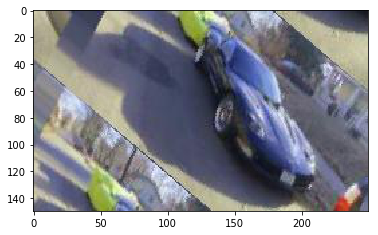

In [93]:
def display_test_img(bucket_name, test_manifest):
    
    test_count = len(test_manifest)
    random_annotation = test_manifest[random.randint(0,test_count-1)]
    s3_uri = random_annotation['path']
    if 'train' in s3_uri:
        root = 'training/'
    else:
        root = 'validation/'
    if 'augmented' in s3_uri:
        root = root + 'augmented/'
    s3_key = os.path.basename(s3_uri)
    local_path = 'images/' + s3_key
#     print(s3_key)
    s3.Bucket(bucket_name).download_file(root+s3_key, local_path)  
    
    raw_img = mpimg.imread(local_path)
    plt.imshow(raw_img)
    return s3_key, local_path

s3_key,local_path = display_test_img(bucket_name, manifest_val)
# print(s3_key)

Image Name damage-val-0119-augmented-0.JPEG
Result: label - Damage, probability - 0.9987484216690063


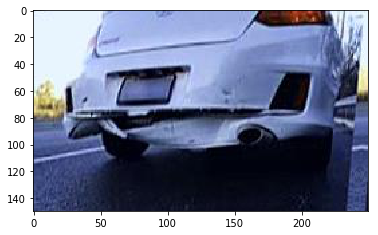

In [94]:
def test_predictor(bucket_name, test_manifest):
    
    s3_key, local_path = display_test_img(bucket_name, test_manifest)

    with open(local_path, 'rb') as f:
        payload = f.read()
        payload = bytearray(payload)
    
    ic_classifier.content_type = 'application/x-image'
    result = json.loads(ic_classifier.predict(payload))
    # the result will output the probabilities for all classes
    # find the class with maximum probability and print the class index
    index = np.argmax(result)
    object_categories = ['No Damage','Damage']
    print('Image Name {}'.format(s3_key))
    print("Result: label - " + object_categories[index] + ", probability - " + str(result[index]))
    
test_predictor(bucket_name, manifest_val)

In [95]:
def retrieve_single_image(bucket_name, manifest_entry):
    
    root = 'testing/'
    s3_uri = manifest_entry['path']
    if 'train' in s3_uri:
        root = 'training/'
    else:
        root = 'validation/'
    if 'augmented' in s3_uri:
        root = root + 'augmented/'
    
    s3_key = os.path.basename(s3_uri)
    local_path = 'images/' + s3_key
    s3.Bucket(bucket_name).download_file(root+s3_key, local_path)  
    
    raw_img = mpimg.imread(local_path)
    return s3_key, local_path

In [96]:
def predict_single_image_and_return_score_label(ic_classifier,s3_key, local_path):
    '''
    Returns: actual_label, predicted_label, confidence_score
    '''
    with open(local_path, 'rb') as f:
        payload = f.read()
        payload = bytearray(payload)
    
    ic_classifier.content_type = 'application/x-image'

    result = json.loads(ic_classifier.predict(payload))
    # the result will output the probabilities for all classes
    # find the class with maximum probability and print the class index
    index = np.argmax(result)
    object_categories = ['No Damage','Damage']
    if 'whole' in s3_key:
        actual_label = 'No Damage'
    else:
        actual_label = 'Damage'
#     print('Image Name {}'.format(s3_key))
#     print("Result: label - " + object_categories[index] + ", probability - " + str(result[index]))
    return actual_label, object_categories[index], result[index]

### Precision Recall Testing

Once we've deployed our model, it's important to ensure that the predictions being made are accurate and useful for a production system. Precision / Recall testing is a traditional method for testing the model's ability to predict accurately, and how well the model finds the correct classes, amongst the entire dataset. Below is the formula used to evaluate the precision and recall of a model. 

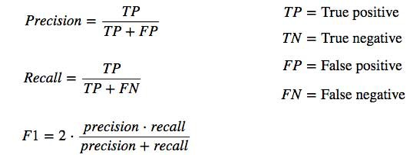

PR is a useful model performance measure/metric for a classification task, however, in more complex prediction scenarions, such as boundary boxes for object detection and image segmentation, other metrics such as Average Precision (AP), is used as a measure, which combines both Precision and Recall, plus Intersection over Union (IoU), which measures the accuracy of a model based on the region within the image it predicts is a specific class.

In [97]:
# os.chdir('Car-Damage-Detector/')
# print(os.getcwd())

def calculate_model_performance(ic_classifer, bucket_name, manifest, printoutput = False):

    tp = 0
    tn = 0
    fp = 0
    fn = 0
    df = pd.DataFrame(columns = ['actual_label','predicted_label','confidence_score'])
    #iterate through all images and predict their class...
    max_inferences = 300
    cnt = 0
    manifest_len = len(manifest)
    for i in range(0, max_inferences) :
            
        entry = manifest[random.randint(0,manifest_len-1)]
        
        s3_key, local_path = retrieve_single_image(bucket_name, entry)
        actual_label, predicted_label, confidence_score = predict_single_image_and_return_score_label(ic_classifer, s3_key, local_path)
#         print(actual_label)

        df.loc[len(df)]=[actual_label, predicted_label, confidence_score] 
        os.remove(local_path)
        cnt +=1
        if cnt >= max_inferences:
            break
    #now we have all the data in the dataframe...
#     print(df)
    pos_class= 'Damage'
    neg_class = 'No Damage'
    for idx,row in df.iterrows():
        if row['actual_label'] == row['predicted_label']:
            
            if row['actual_label'] == pos_class:
                tp += 1
            else:
                tn += 1
        else:
            if row['actual_label'] == pos_class:
                fn += 1
            else:
                fp += 1
            
    
    positive_classes = df['actual_label'][df.actual_label == pos_class].count()
    negative_classes = df['actual_label'][df.actual_label == neg_class].count()
    
    class_report = classification_report(df['actual_label'], df['predicted_label'])
    
    if printoutput:
        print('Positive Records {}, Negative Records {}'.format(positive_classes, negative_classes))
        print('Detection Results (Absolute):')
        print('True Positive {}'.format(tp))
        print('True Negative {}'.format(tn))
        print('False Positive {}'.format(fp))
        print('False Negative {}'.format(fn))

        #And use Classification Report from Skit-Learn
        target_names = ['Positive', 'Negative']
        print(class_report)#, target_names=target_names))
        
    return class_report, tp, tn, fp, fn

              
    
lass_report = calculate_model_performance(cdd.predictor, bucket_name, manifest_val, printoutput = True)


Positive Records 264, Negative Records 36
Detection Results (Absolute):
True Positive 264
True Negative 0
False Positive 36
False Negative 0
              precision    recall  f1-score   support

      Damage       0.88      1.00      0.94       264
   No Damage       0.00      0.00      0.00        36

   micro avg       0.88      0.88      0.88       300
   macro avg       0.44      0.50      0.47       300
weighted avg       0.77      0.88      0.82       300



/home/ec2-user/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


---


## Part 2. Object Detector - Pre-Trained

In Part 2, we're going to demonstrate the use of a pre-trained model for object detection.

The following code demonstrates the use of a Object-Detection Model, which has been pretrained on a subset of the COCO 2017 Dataset, for more information please visit: http://cocodataset.org/#home

To examine how this model was developed, please check out the following [notebook](Car-Detector/object_detection_image_json_format.ipynb)

In [57]:
from objectdetector import ObjectDetector

In [58]:
#Create a new ObjectDetector Object, and specify the endpoint name (this is name that is visbile in the AWS Console)
od = ObjectDetector('object-detection-2020-03-06-04-04-36-981')

Instantiating ObjectDetector
Adding Class Labels
Added 80 Class Labels


downloading Image from https://pixnio.com/free-images/2019/10/02/2019-10-02-10-31-07.jpg
Saved Image to test-image.jpg


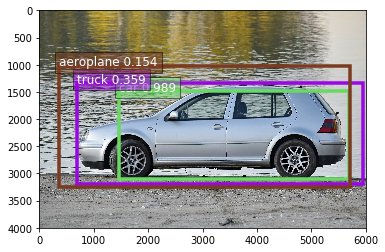

{'car': 0.9885451197624207,
 'truck': 0.358900785446167,
 'aeroplane': 0.15427656471729279}

In [69]:
image_url = 'https://pixnio.com/free-images/2019/10/02/2019-10-02-10-31-07.jpg'
image_local_path = od.download_image(image_url, to_save_filename='test-image.jpg')
od.visualize_detection(image_local_path, 0.1)

---

## Part 3. Demonstration of Both Models Working Together

In the following example, we're going to show what happens if we use both models to support an example where we need to determine whether first, the image contains a car, and second, whether the car is damaged or not. The justification of why we have separate models is based on needing specific classifiers trained for different purposes.

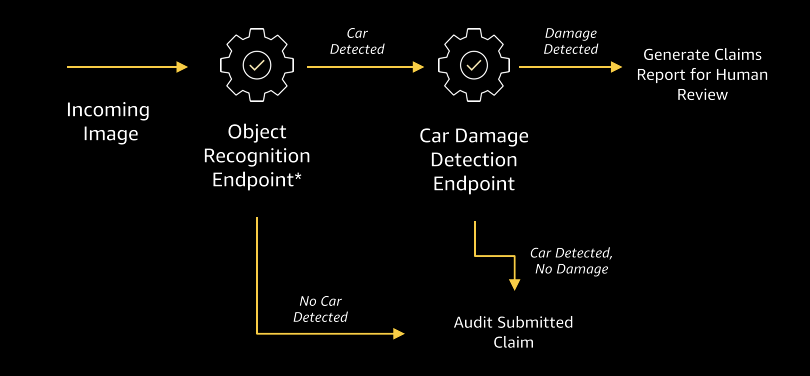

In [62]:
# os.chdir('../src/')
print(os.getcwd())
from objectdetector import ObjectDetector
from cardamagedetector import CarDamageDetector

/home/ec2-user/SageMaker/Car-Damage-Detector


In [64]:
od = ObjectDetector('object-detection-2020-03-06-04-04-36-981')
cdd = CarDamageDetector('image-classification-2020-02-28-06-52-00-232')

Instantiating ObjectDetector
Adding Class Labels
Added 80 Class Labels
Instantiating Car Damage Detector
Adding Class Labels
Added 2 Class Labels


In [65]:
def determine_if_needs_audit_or_filing(od, cdd, image_url, acceptable_thresh = 0.1):
    
    obj_to_detect = 'car'
    expected_predicted_class = 'Damage'
    #download the image
    image_local_path = od.download_image(image_url, to_save_filename='test-image.jpg')
    #score the image with the first model
    classes_and_scores = od.visualize_detection(image_local_path, acceptable_thresh)
    print(classes_and_scores)
    #1. first run it through the obhect detector

    goto_second_classifier = False
    #Determine if a car exists in the object
    if obj_to_detect in classes_and_scores:
        if classes_and_scores[obj_to_detect] > acceptable_thresh:
            goto_second_classifier = True
    
    if goto_second_classifier:    
    #2. Now check if the image contains a damaged vehicle
        predicted_class = cdd.predict_if_contains_damage(image_local_path)
        if expected_predicted_class == 'Damage':
            print('No Audit Needed, execute workflow to create report')
        else:
            print('Audit Required')
        

downloading Image from https://image.shutterstock.com/z/stock-photo-isolate-side-of-the-car-the-color-of-braun-white-which-crashed-with-another-car-until-it-was-596238068.jpg
Saved Image to test-image.jpg


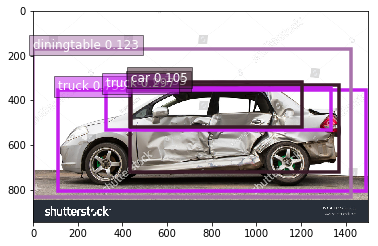

{'truck': 0.2966732382774353, 'car': 0.10488106310367584, 'diningtable': 0.12327953428030014}
Image Name test-image.jpg
Result: label - Damage, probability - 0.9999725818634033
No Audit Needed, execute workflow to create report


In [66]:
determine_if_needs_audit_or_filing(od, cdd, image_url = 'https://image.shutterstock.com/z/stock-photo-isolate-side-of-the-car-the-color-of-braun-white-which-crashed-with-another-car-until-it-was-596238068.jpg')

downloading Image from https://pixnio.com/free-images/2019/06/26/2019-06-26-14-22-51-1200x900.jpg
Saved Image to test-image.jpg


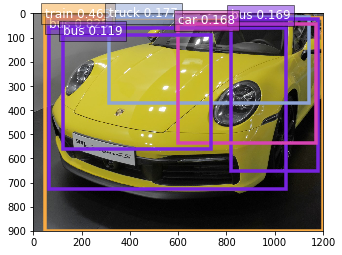

{'bus': 0.1194419339299202, 'train': 0.4647209346294403, 'truck': 0.17723286151885986, 'car': 0.16832076013088226}
Image Name test-image.jpg
Result: label - Damage, probability - 0.99959796667099
No Audit Needed, execute workflow to create report


In [73]:
url_not_damaged = 'https://pixnio.com/free-images/2019/06/26/2019-06-26-14-22-51-1200x900.jpg'
determine_if_needs_audit_or_filing(od, cdd, image_url= url_not_damaged)